# Node Classification Practice - Wisconsin Dataset

## Installation of Required Libraries and Packages

In [1]:
#Libraries we are going to use
# Install required packages.
import os
import torch #Library for deep learning
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
COLLAB_ENV = True
if COLLAB_ENV:
    !pip install 'scipy>=1.8'
    !pip install mycolorpy
import numpy as np #Library for linear algebra
import matplotlib.pyplot as plt #Library for plotting
import networkx as nx #Library for graph
from torch_geometric.datasets import Planetoid,WebKB #Library for graph dataset and deep learning on graphs
from torch_geometric.utils import to_dense_adj
import warnings
warnings.filterwarnings("ignore") # Get rid of warnings

# Instalaciones e importaciones adicionales
#!pip install torch-cluster
from torch_geometric.nn import knn_graph
from torch_geometric.nn import GATConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GINConv
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear



2.2.0


## Loading and Visualization of the Dataset

In [2]:
'''
    Load the dataset:
        * root: The root directory where the dataset should be saved.
        * name: The name of the dataset (cora, citeseer or pubmed).
        * transform: A function/transform that takes in an Data object of the dataset and returns a transformed version. The data object will be transformed before every access.
    Returns:
        * Dataset object
'''
from torch_geometric.datasets import WebKB

dataset = WebKB(root='/tmp/Wisconsin', name='Wisconsin') # Load the Wisconsin dataset
data = dataset[0] # Get the first graph object (in this case is only one graph, while in Graph classification there are multiple graphs)
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print()
print(data) # Note that the adjacency matrix is not stored explicitly but in the edge_index attribute.
            # The edge_index attribute is a 2 x E tensor, with each column denoting an edge.
            # The first row denotes the source nodes and the second row the destination nodes of the edges.
            # The nodes are numbered consecutively starting from zero.
            # The features are stored in the x attribute, which is a N x F tensor, with N being the number of nodes and F the number of features per node.
            # The labels are stored in the y attribute, which is a vector of length N, with each entry denoting the class of the corresponding node.
print('===========================================================================================================')
adj = to_dense_adj(data.edge_index)[0] # Convert the sparse adjacency matrix to a dense adjacency matrix
print("Shape of the new adjacency matrix: ",adj.shape)
#Let's get statistics about the graph adjacency matrix
print("Number of nodes: ",adj.shape[0])
print("Number of edges: ",round(adj.sum().item()))
print("Density: ",round((adj.sum()/(adj.shape[0]*adj.shape[0])).item(),4))
print("Maximum node degree: ",round(adj.sum(axis=1).max().item()))
print("Minimum node degree: ",round(adj.sum(axis=1).min().item()))
print("Average node degree: ",round(adj.sum(axis=1).mean().item()))
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print('===========================================================================================================')

# Variables necesarias
IN_CHANNELS = data.x.size(1)
HIDDEN_CHANNELS = 16
OUT_CHANNELS = dataset.num_classes


Dataset: wisconsin():
Number of graphs: 1
Number of features: 1703
Number of classes: 5

Data(x=[251, 1703], edge_index=[2, 515], y=[251], train_mask=[251, 10], val_mask=[251, 10], test_mask=[251, 10])
Shape of the new adjacency matrix:  torch.Size([251, 251])
Number of nodes:  251
Number of edges:  515
Density:  0.0082
Maximum node degree:  122
Minimum node degree:  0
Average node degree:  2
Has isolated nodes: False
Has self-loops: True
Is undirected: False


Processing...
Done!


Data(x=[251, 1703], edge_index=[2, 916], y=[251], train_mask=[251, 10], val_mask=[251, 10], test_mask=[251, 10], num_nodes=251, num_edges=466)


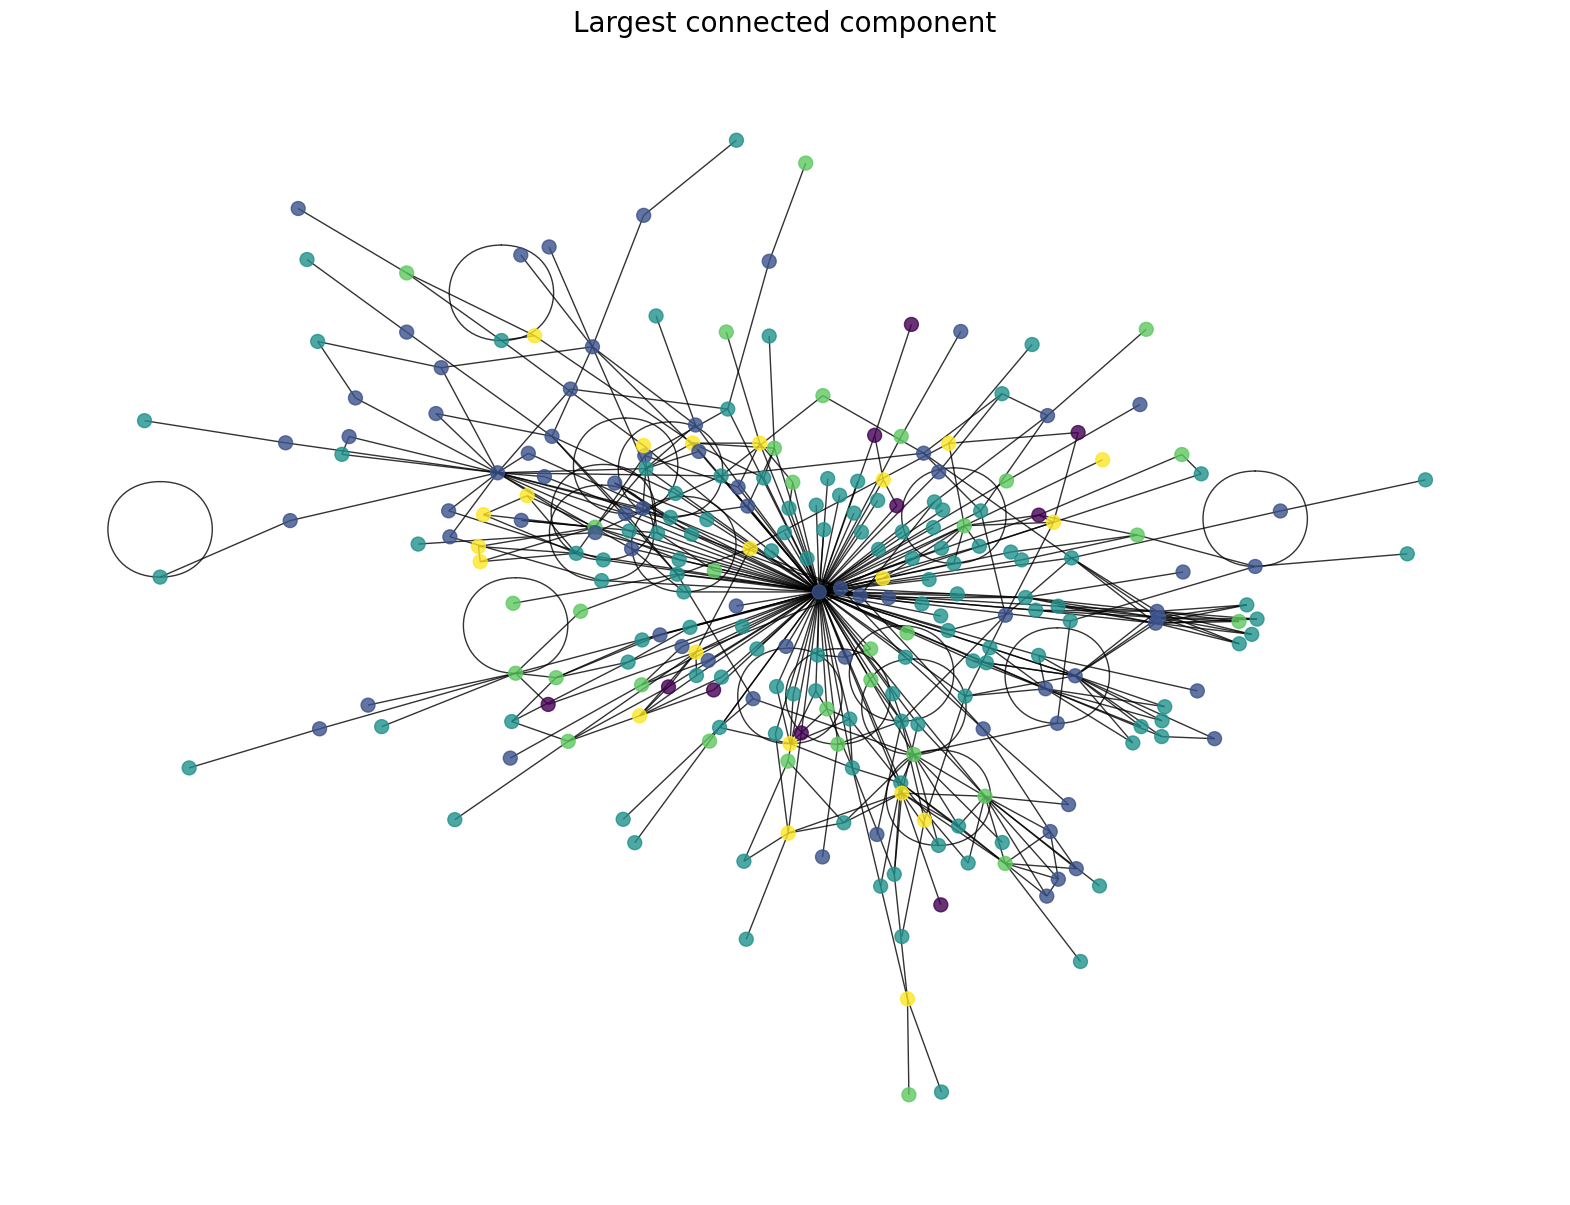

In [3]:
# To visualize the graph we are going to use networkx library, but first we need to convert the graph to networkx format
from torch_geometric.utils import to_networkx
A = to_networkx(data, to_undirected=True) # Convert the graph to networkx format
# Now we are going to get the largest connected component of the graph, because the graph is not connected!
Gcc = sorted(nx.connected_components(A), key=len, reverse=True) # Get the sorted list of connected components
A = A.subgraph(Gcc[0]) # Get the largest connected component
G = nx.adjacency_matrix(A)
# All the following code is just for plotting the graph, so you can ignore it
# This how we can get the edge_index attribute for the largest connected component
g_tensor = torch.tensor(G.todense())
new_edge_index = g_tensor.nonzero().t().contiguous()
# This is how we create the new data object for the largest connected component
data.x = data.x[list(A.nodes())]
data.y = data.y[list(A.nodes())]
data.edge_index = new_edge_index
data.num_nodes = len(A.nodes())
data.num_edges = len(A.edges())
print(data)
# Now we can plot the graph
A = to_networkx(data, to_undirected=True) # Convert the graph to networkx format
plt.figure(figsize=(20,15))
plt.title('Largest connected component',fontsize=20)
pos = nx.spring_layout(A,seed=12)
#Let's drow the graph, adding borders to the nodes
'''
    Arguments of nx.draw:
        * G: The graph to draw.
        * node_color: The color of the nodes.
        * pos: A dictionary with nodes as keys and positions as values.
        * cmap: A colormap or registered colormap name.
        * node_size: The size of the nodes.
        * edge_color: The color of the edges.
        * width: The width of the edges.
        * with_labels: Whether to draw the node labels.
        * node_shape: The shape of the nodes.
        * alpha: The node transparency.
    Returns:
        * None
'''
nx.draw(A,node_color=data.y,pos= pos, cmap=plt.cm.viridis, node_size=100, edge_color='black',width=1,with_labels=False,node_shape='o',alpha=0.8)
plt.show()

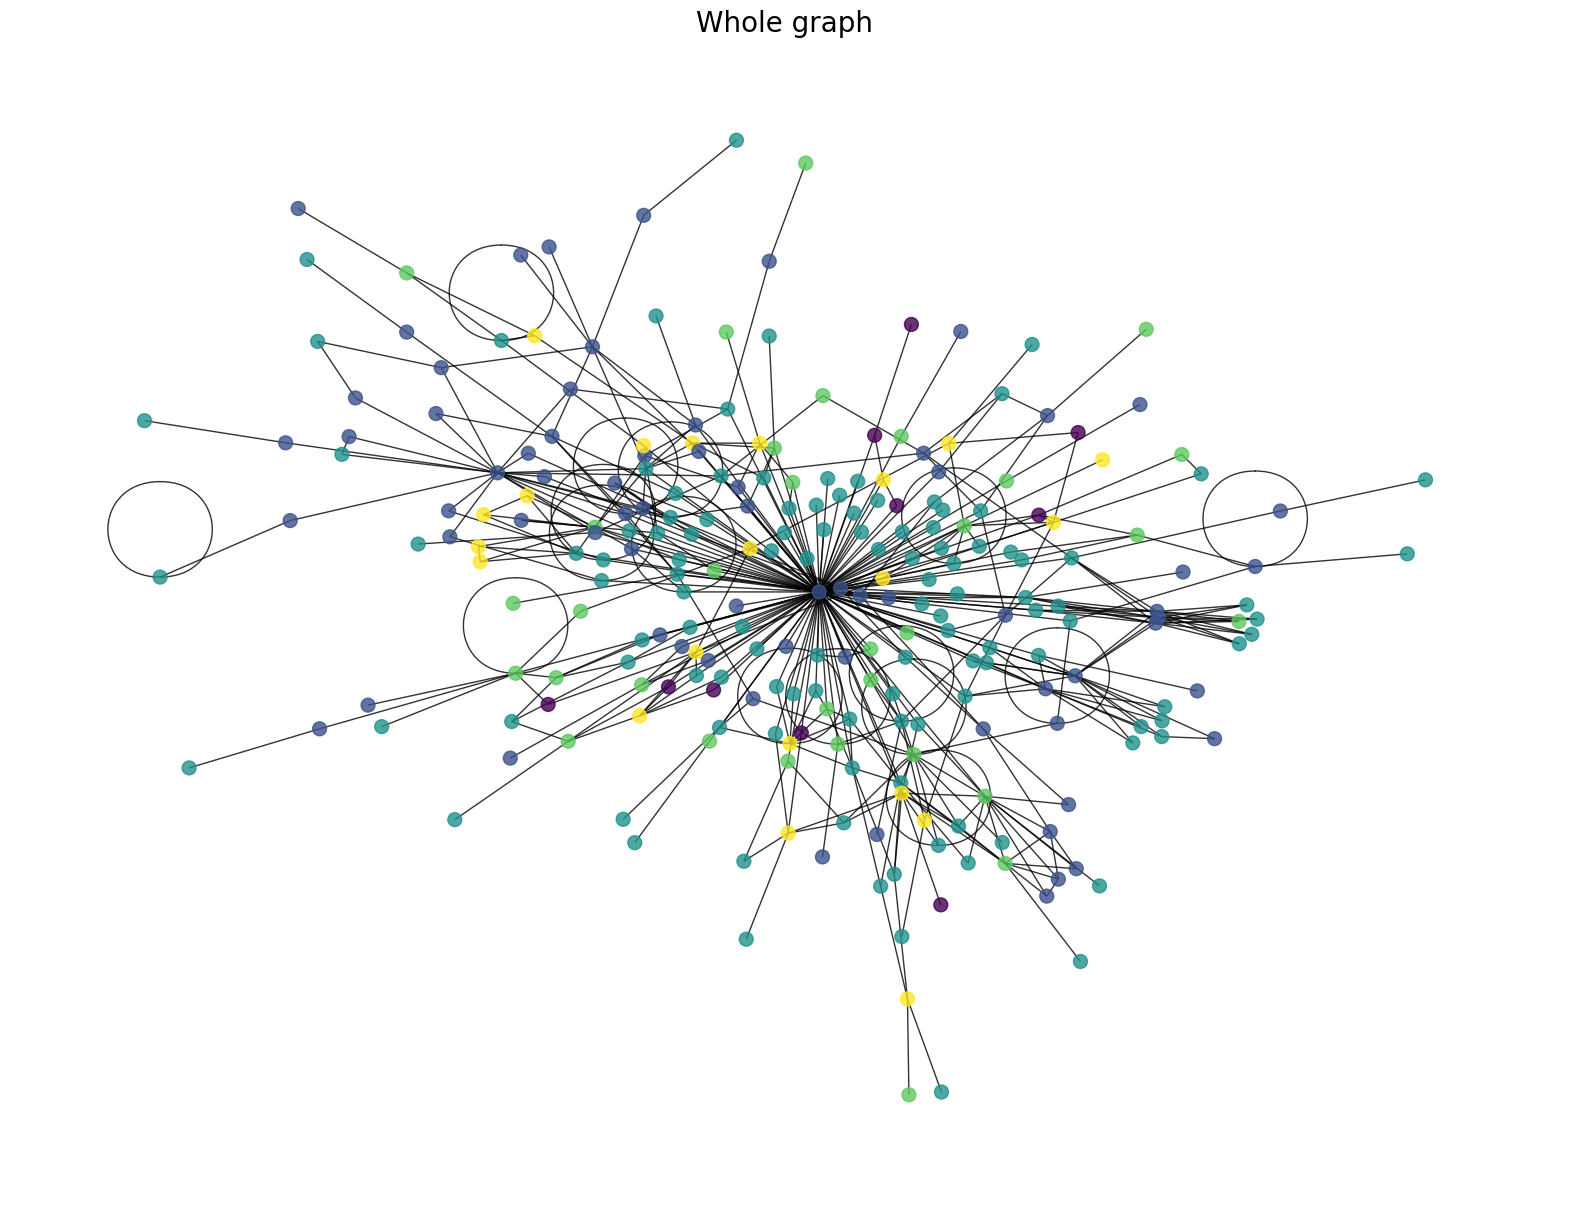

In [4]:
# The same as above but with the whole graph
data = dataset[0]
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(20,15))
plt.title('Whole graph',fontsize=20)
color = data.y
pos = nx.spring_layout(G,seed=12)
nx.draw(G,node_color=color,pos= pos, cmap=plt.cm.viridis, node_size=100, edge_color='black',width=1,with_labels=False,node_shape='o',alpha=0.8)
plt.show()


## Utility Functions: train, validation and test

In [3]:
'''
    Arguments of train:
        * model: The model to train.
        * data: The data object.
        * optimizer: The optimizer to use.
        * train_mask: The mask of the training nodes.
        * criterion: The loss function to use.
    Returns:
        * loss: The loss of the model.
        * acc: The accuracy of the model.
'''
def train(model, data, optimizer,train_mask,device,criterion = torch.nn.CrossEntropyLoss()):
    model.train()
    optimizer.zero_grad() # Clear gradients.
    #Make sure that we only use the features of the training nodes
    features = torch.zeros(data.x.shape[0],data.x.shape[1]).to(device)
    features[train_mask] = data.x[train_mask]
    # Put the features in the same device as the model
    features = features.to(device)
    out = model(features, data.edge_index) # Perform a single forward pass.
    loss = criterion(out[train_mask], data.y[train_mask]) # Compute the loss solely based on the training nodes.
    pred = out.argmax(dim=1) # Use the class with highest probability.
    acc = pred[train_mask].eq(data.y[train_mask]).sum().item() / train_mask.sum().item() # Derive ratio of correct predictions.
    loss.backward() # Derive gradients.
    optimizer.step() # Update parameters based on gradients.
    return loss,acc
'''
    Arguments of validation:
        * model: The model to train.
        * data: The data object.
        * val_mask: The mask of the validation nodes.
    Returns:
        * acc: The accuracy of the model.
'''
@torch.no_grad()
def validation(model,data,val_mask,device):
    model.eval() # Set model to evaluation mode (e.g. disable dropout)
    #Make sure that we only use the features of the validation nodes
    features = torch.zeros(data.x.shape[0],data.x.shape[1]).to(device)
    features[val_mask] = data.x[val_mask]
    # Put the features in the same device as the model
    features = features.to(device)
    out = model(features, data.edge_index)
    pred = out.argmax(dim=1) # Use the class with highest probability.
    acc = pred[val_mask].eq(data.y[val_mask]).sum().item() / val_mask.sum().item() # Derive ratio of correct predictions.
    return acc
'''
    Arguments of test:
        * model: The model to train.
        * data: The data object.
        * test_mask: The mask of the test nodes.
    Returns:
        * acc: The accuracy of the model.
'''
@torch.no_grad()
def test(model,data,test_mask,device):
    model.eval() # Set model to evaluation mode (e.g. disable dropout)
    #Make sure that we only use the features of the testing nodes
    features = torch.zeros(data.x.shape[0],data.x.shape[1]).to(device)
    features[test_mask] = data.x[test_mask]
    # Put the features in the same device as the model
    features = features.to(device)
    out = model(features, data.edge_index)
    pred = out.argmax(dim=1) # Use the class with highest probability.
    acc = pred[test_mask].eq(data.y[test_mask]).sum().item() / test_mask.sum().item() # Derive ratio of correct predictions.
    return acc

## Utility Functions: get_semi_supervised_split and get_supervised_split

In [4]:
from sklearn.model_selection import train_test_split
'''
    Arguments of get_semi_supervised_split:
        * data: The data object.
        * seed: The seed to use for the random split.
    Returns: the train, test and validation masks with an 48%/32%/20%.
        * train_mask: The mask of the training nodes.
        * test_mask: The mask of the test nodes.
        * val_mask: The mask of the validation nodes.
'''
def get_semi_supervised_split(data,seed):
    #We are going to use 48% of the nodes for training, 32% for testing and 20% for validation
    #First we split the nodes in 80% for training and 20% for testing
    #Then we split the training nodes in 48% for training and 32% for validation over the 80% of the nodes
    train_split, test_split = train_test_split(list(range(len(data.y))), test_size=0.20,random_state=seed, shuffle=True)
    train_split, val_split = train_test_split(train_split, test_size=0.40,random_state=seed, shuffle=True)

    train_mask = torch.full_like(data.y, False, dtype=bool)
    train_mask[train_split] = True

    test_mask = torch.full_like(data.y, False, dtype=bool)
    test_mask[test_split] = True

    val_mask = torch.full_like(data.y, False, dtype=bool)
    val_mask[val_split] = True

    return train_mask,test_mask,val_mask
'''
    Arguments of get_supervised_split:
        * data: The data object.
        * seed: The seed to use for the random split.
    Returns: the train, test and validation masks with an 60%/20%/20%.
        * train_mask: The mask of the training nodes.
        * test_mask: The mask of the test nodes.
        * val_mask: The mask of the validation nodes.
'''
def get_supervised_split(data,seed):
    train_split, test_split = train_test_split(list(range(len(data.y))), test_size=0.40,random_state=seed, shuffle=True)
    test_split, val_split = train_test_split(test_split, test_size=0.50,random_state=seed, shuffle=True)

    train_mask = torch.full_like(data.y, False, dtype=bool)
    train_mask[train_split] = True

    test_mask = torch.full_like(data.y, False, dtype=bool)
    test_mask[test_split] = True

    val_mask = torch.full_like(data.y, False, dtype=bool)
    val_mask[val_split] = True

    return train_mask, test_mask, val_mask

## Creation of Models

### GCN

In [7]:
from torch_geometric.nn import GCNConv
from torch.functional import F
'''
    In PyTorch, you define a model by subclassing torch.nn.Module and defining a forward() method which receives input data and returns output data.
    The forward() method can use other modules defined in the constructor as submodules, and it can use arbitrary operators on Tensors, including loops and conditional statements.
    This approach is very flexible, and you can use it to define models of arbitrary complexity.
'''
class GCN(torch.nn.Module):
    '''
        Arguments of __init__:
            * hidden_channels: The number of hidden units.
            * dataset.num_features: The number of input features.
            * dataset.num_classes: The number of output classes.
        Returns:
            * self.conv1: The first GCN layer.
            * self.conv2: The second GCN layer.
    '''
    def __init__(self,hidden_channels = 16):
        super(GCN, self).__init__()
        # 2-layer GCN
        self.conv1 = GCNConv(dataset.num_features, hidden_channels) # 32 hidden units
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes) # dataset.num_classes output units
    '''
        Arguments of forward:
            * x: The input features.
            * edge_index: The edge indices.
        Returns:
            * F.softmax(x, dim=1): The output of the model.
    '''
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index)) # ReLU activation
        x = F.dropout(x,p=0.5, training=self.training) # Dropout: 50% of the nodes are randomly dropped out during training
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1) # Log softmax activation
print(GCN())

GCN(
  (conv1): GCNConv(1703, 16)
  (conv2): GCNConv(16, 5)
)


### MLP

In [8]:
from torch.nn import Linear
# Same as GCN but with Linear layers instead of GCNConv layers. If we use MLP as a model, we can't take into account the graph STRUCTURE.
class MLP(torch.nn.Module):
    def __init__(self,hidden_channels = 16):
        super(MLP, self).__init__()
        # 2-layer GCN
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # edge_index is not used
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x.softmax(dim=1)
print(MLP())

MLP(
  (lin1): Linear(in_features=1703, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=5, bias=True)
)


### Basic Models

In [9]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS, num_heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * num_heads, out_channels, heads=num_heads)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1)

print(GAT())

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1)

print(GraphSAGE())

class GIN(torch.nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS):
        super(GIN, self).__init__()
        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels)))
        self.conv2 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, out_channels)))

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1)

print(GIN())


GAT(
  (conv1): GATConv(1703, 16, heads=8)
  (conv2): GATConv(128, 5, heads=8)
)
GraphSAGE(
  (conv1): SAGEConv(1703, 16, aggr=mean)
  (conv2): SAGEConv(16, 5, aggr=mean)
)
GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1703, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=5, bias=True)
  ))
)


### Complex Models

In [10]:
class GCN2(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super(GCN2, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels * 50)
        self.conv2 = GCNConv(hidden_channels * 50, hidden_channels * 20)
        self.conv3 = GCNConv(hidden_channels * 20, hidden_channels * 5)
        self.conv4 = GCNConv(hidden_channels * 5, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv4(x, edge_index)
        return F.softmax(x, dim=1)

print(GCN2())


class MLP2(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super(MLP2, self).__init__()
        self.lin1 = Linear(dataset.num_features, hidden_channels * 50)
        self.lin2 = Linear(hidden_channels * 50, hidden_channels * 20)
        self.lin3 = Linear(hidden_channels * 20, hidden_channels * 5)
        self.lin4 = Linear(hidden_channels * 5, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.lin3(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin4(x)
        return F.softmax(x, dim=1)

print(MLP2())


class GAT2(torch.nn.Module):
    def __init__(self, hidden_channels=16, num_heads=8):
        super(GAT2, self).__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels * 50, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * 50 * num_heads, hidden_channels * 20, heads=num_heads)
        self.conv3 = GATConv(hidden_channels * 20 * num_heads, hidden_channels * 5, heads=num_heads)
        self.conv4 = GATConv(hidden_channels * 5 * num_heads, dataset.num_classes, heads=num_heads)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv4(x, edge_index)
        return F.softmax(x, dim=1)

print(GAT2())



class GraphSAGE2(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super(GraphSAGE2, self).__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels * 50)
        self.conv2 = SAGEConv(hidden_channels * 50, hidden_channels * 20)
        self.conv3 = SAGEConv(hidden_channels * 20, hidden_channels * 5)
        self.conv4 = SAGEConv(hidden_channels * 5, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv4(x, edge_index)
        return F.softmax(x, dim=1)

print(GraphSAGE2())



class GIN2(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super(GIN2, self).__init__()
        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(dataset.num_features, hidden_channels * 50),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels * 50, hidden_channels * 20)))
        self.conv2 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels * 20, hidden_channels * 20),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels * 20, hidden_channels * 5)))
        self.conv3 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels * 5, hidden_channels * 5),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels * 5, hidden_channels * 5)))
        self.conv4 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels * 5, hidden_channels * 5),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels * 5, dataset.num_classes)))

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv4(x, edge_index)
        return F.softmax(x, dim=1)

print(GIN2())



GCN2(
  (conv1): GCNConv(1703, 800)
  (conv2): GCNConv(800, 320)
  (conv3): GCNConv(320, 80)
  (conv4): GCNConv(80, 5)
)
MLP2(
  (lin1): Linear(in_features=1703, out_features=800, bias=True)
  (lin2): Linear(in_features=800, out_features=320, bias=True)
  (lin3): Linear(in_features=320, out_features=80, bias=True)
  (lin4): Linear(in_features=80, out_features=5, bias=True)
)
GAT2(
  (conv1): GATConv(1703, 800, heads=8)
  (conv2): GATConv(6400, 320, heads=8)
  (conv3): GATConv(2560, 80, heads=8)
  (conv4): GATConv(640, 5, heads=8)
)
GraphSAGE2(
  (conv1): SAGEConv(1703, 800, aggr=mean)
  (conv2): SAGEConv(800, 320, aggr=mean)
  (conv3): SAGEConv(320, 80, aggr=mean)
  (conv4): SAGEConv(80, 5, aggr=mean)
)
GIN2(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1703, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=320, bias=True)
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=320, out_features=320, bias=True)
    (

## Basic Models Training

In [11]:
# Seeds for the random split. This allows us to reproduce the results.
RandList = [12345, 423456, 643451, 543452, 743456, 4734510, 654321, 124321, 945321, 784328]
# This allows us to run the code on the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Here you can add models to train and test (include your own models)
models = [GCN(), MLP(), GAT(), GraphSAGE(), GIN()]
global_results = []
global_best_models = []

cuda


In [12]:
for j in range(len(models)):
    ExperimentResult = []
    best_model = None
    #print(data)
    for i in range(10):
        #print("Random State", RandList[i]," in the iteration",i)
        train_mask,test_mask,val_mask = get_semi_supervised_split(data.cpu(), RandList[i])
        #train_mask,test_mask,val_mask = get_supervised_split(data.cpu(), RandList[i])
        data = data.to(device)
        model = models[j].to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        for epoch in range(1, 101):
            loss, acc_train = train(model,data,optimizer,train_mask.to(device),device=device)
            acc_validation = validation(model,data,val_mask.to(device),device=device)
            #print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Val Acc: {:.5f}'.format(epoch, loss, acc_train, acc_validation))
        acc = test(model,data,test_mask.to(device),device=device)
        #print('Test Accuracy: {:.5f}'.format(acc))
        # Save the best model over the 10 runs
        if best_model is None or acc > best_model[1]:
            best_model = [model, acc]
        ExperimentResult.append(acc)
        del model
    print(models[j].__class__.__name__) # Name of the model
    print('{} +- {}'.format(np.mean(ExperimentResult)*100, np.std(ExperimentResult)*100))
    global_results.append(ExperimentResult.copy())
    global_best_models.append(best_model.copy())

GCN
70.3921568627451 +- 6.410895185988948
MLP
88.43137254901961 +- 6.470588235294117
GAT
75.88235294117648 +- 5.88562000776613
GraphSAGE
89.01960784313727 +- 6.395884874627485
GIN
70.0 +- 8.458688082401173


## Basic Models Results: Visualization

### Boxplot and Lineplot

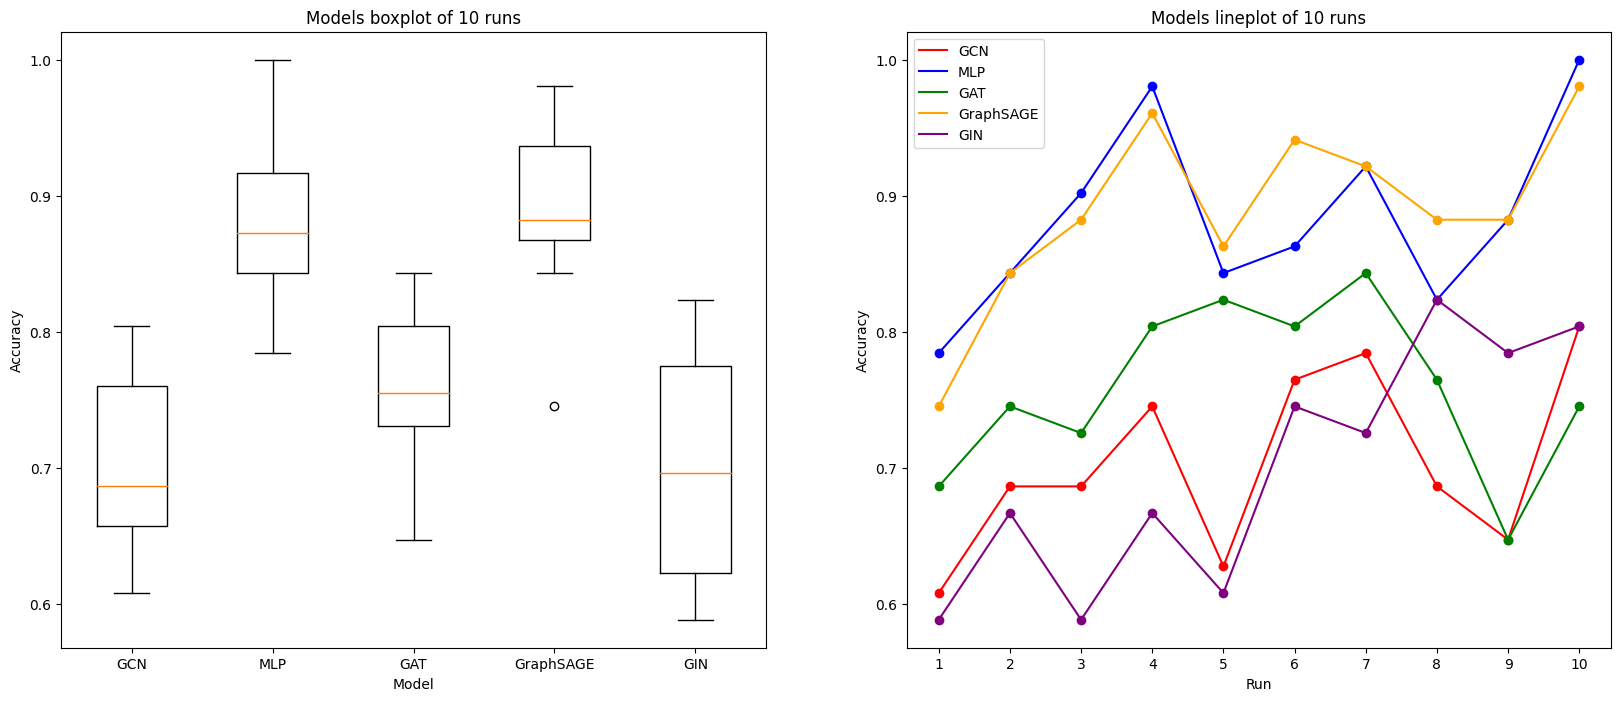

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Boxplot
axs[0].set_title('Models boxplot of 10 runs')
axs[0].boxplot(global_results, labels=['GCN', 'MLP', 'GAT', 'GraphSAGE', 'GIN'])
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Accuracy')

# Lineplot
axs[1].set_title('Models lineplot of 10 runs')

# Plotting each model's results
colors = ['red', 'blue', 'green', 'orange', 'purple']
labels = ['GCN', 'MLP', 'GAT', 'GraphSAGE', 'GIN']
for i, model_results in enumerate(global_results):
    axs[1].plot(range(1, 11), model_results, 'ro', color=colors[i])
    axs[1].plot(range(1, 11), model_results, color=colors[i], label=labels[i])

axs[1].set_xticks(range(1, 11))
axs[1].set_xlabel('Run')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()


### t-SNE

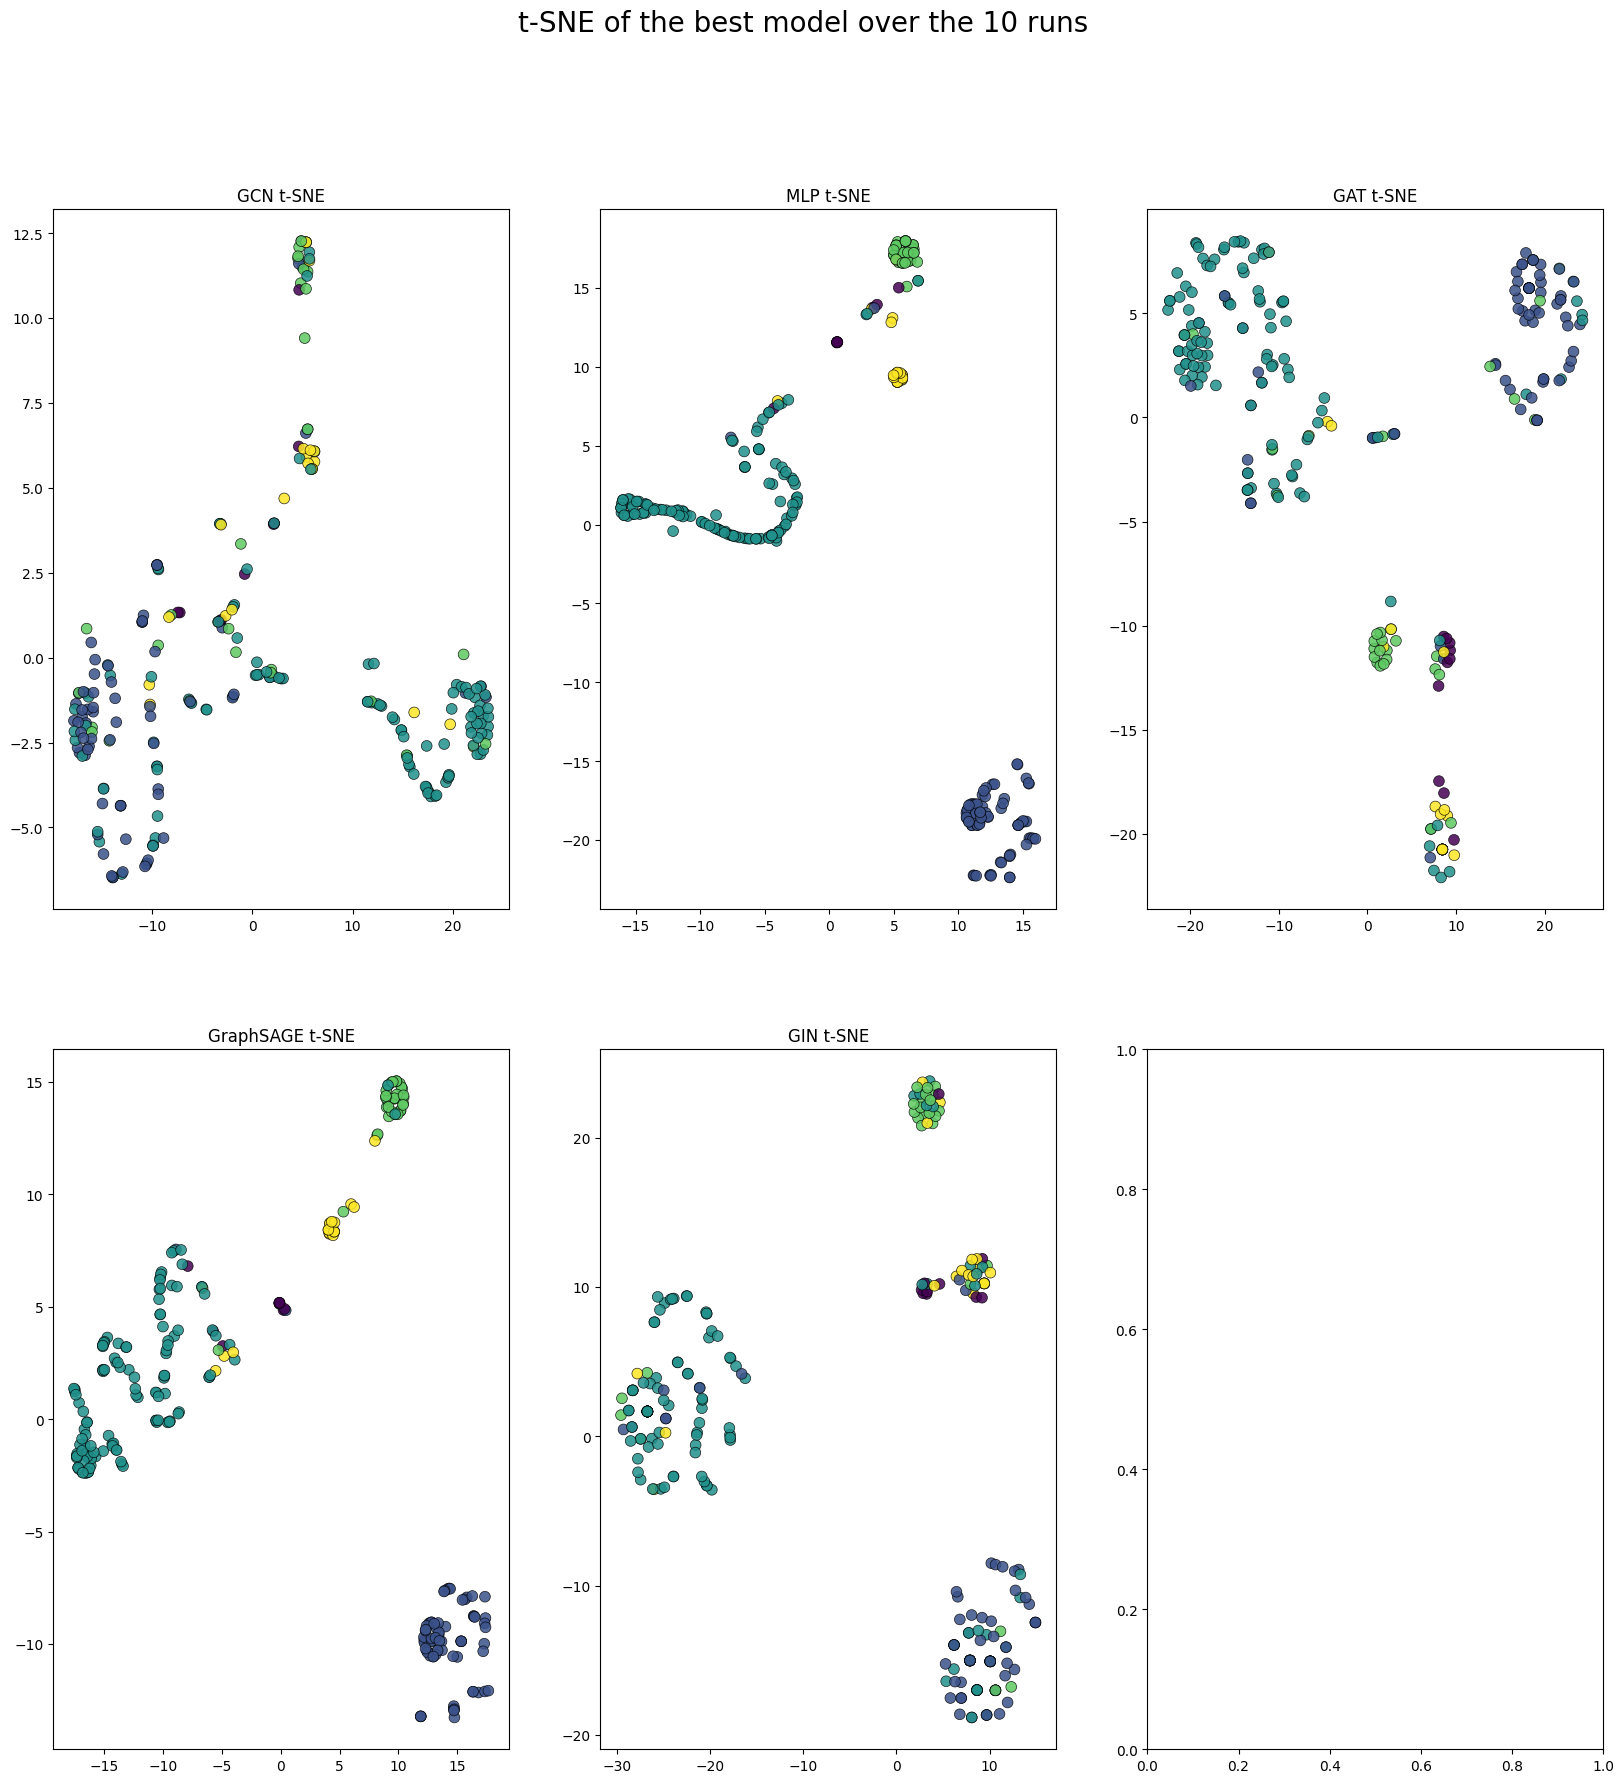

In [14]:
from sklearn.manifold import TSNE

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

# Para recorrer los subplots
subplot_index = 0

for i, (model, model_name) in enumerate(zip(models, ['GCN', 'MLP', 'GAT', 'GraphSAGE', 'GIN'])):
    out_model = global_best_models[i][0](data.x, data.edge_index)
    tsne = TSNE(n_components=2, random_state=12345)
    tsne_results = tsne.fit_transform(out_model.detach().cpu().numpy())

    row_index = i // 3
    col_index = i % 3

    axs[row_index, col_index].set_title(f'{model_name} t-SNE')
    axs[row_index, col_index].scatter(tsne_results[:, 0], tsne_results[:, 1], c=data.y.cpu(), cmap='viridis', s=60, alpha=0.85, edgecolors='black', linewidths=0.5)
    subplot_index += 1

fig.suptitle('t-SNE of the best model over the 10 runs', fontsize=20)
plt.show()


### Confusion Matrix

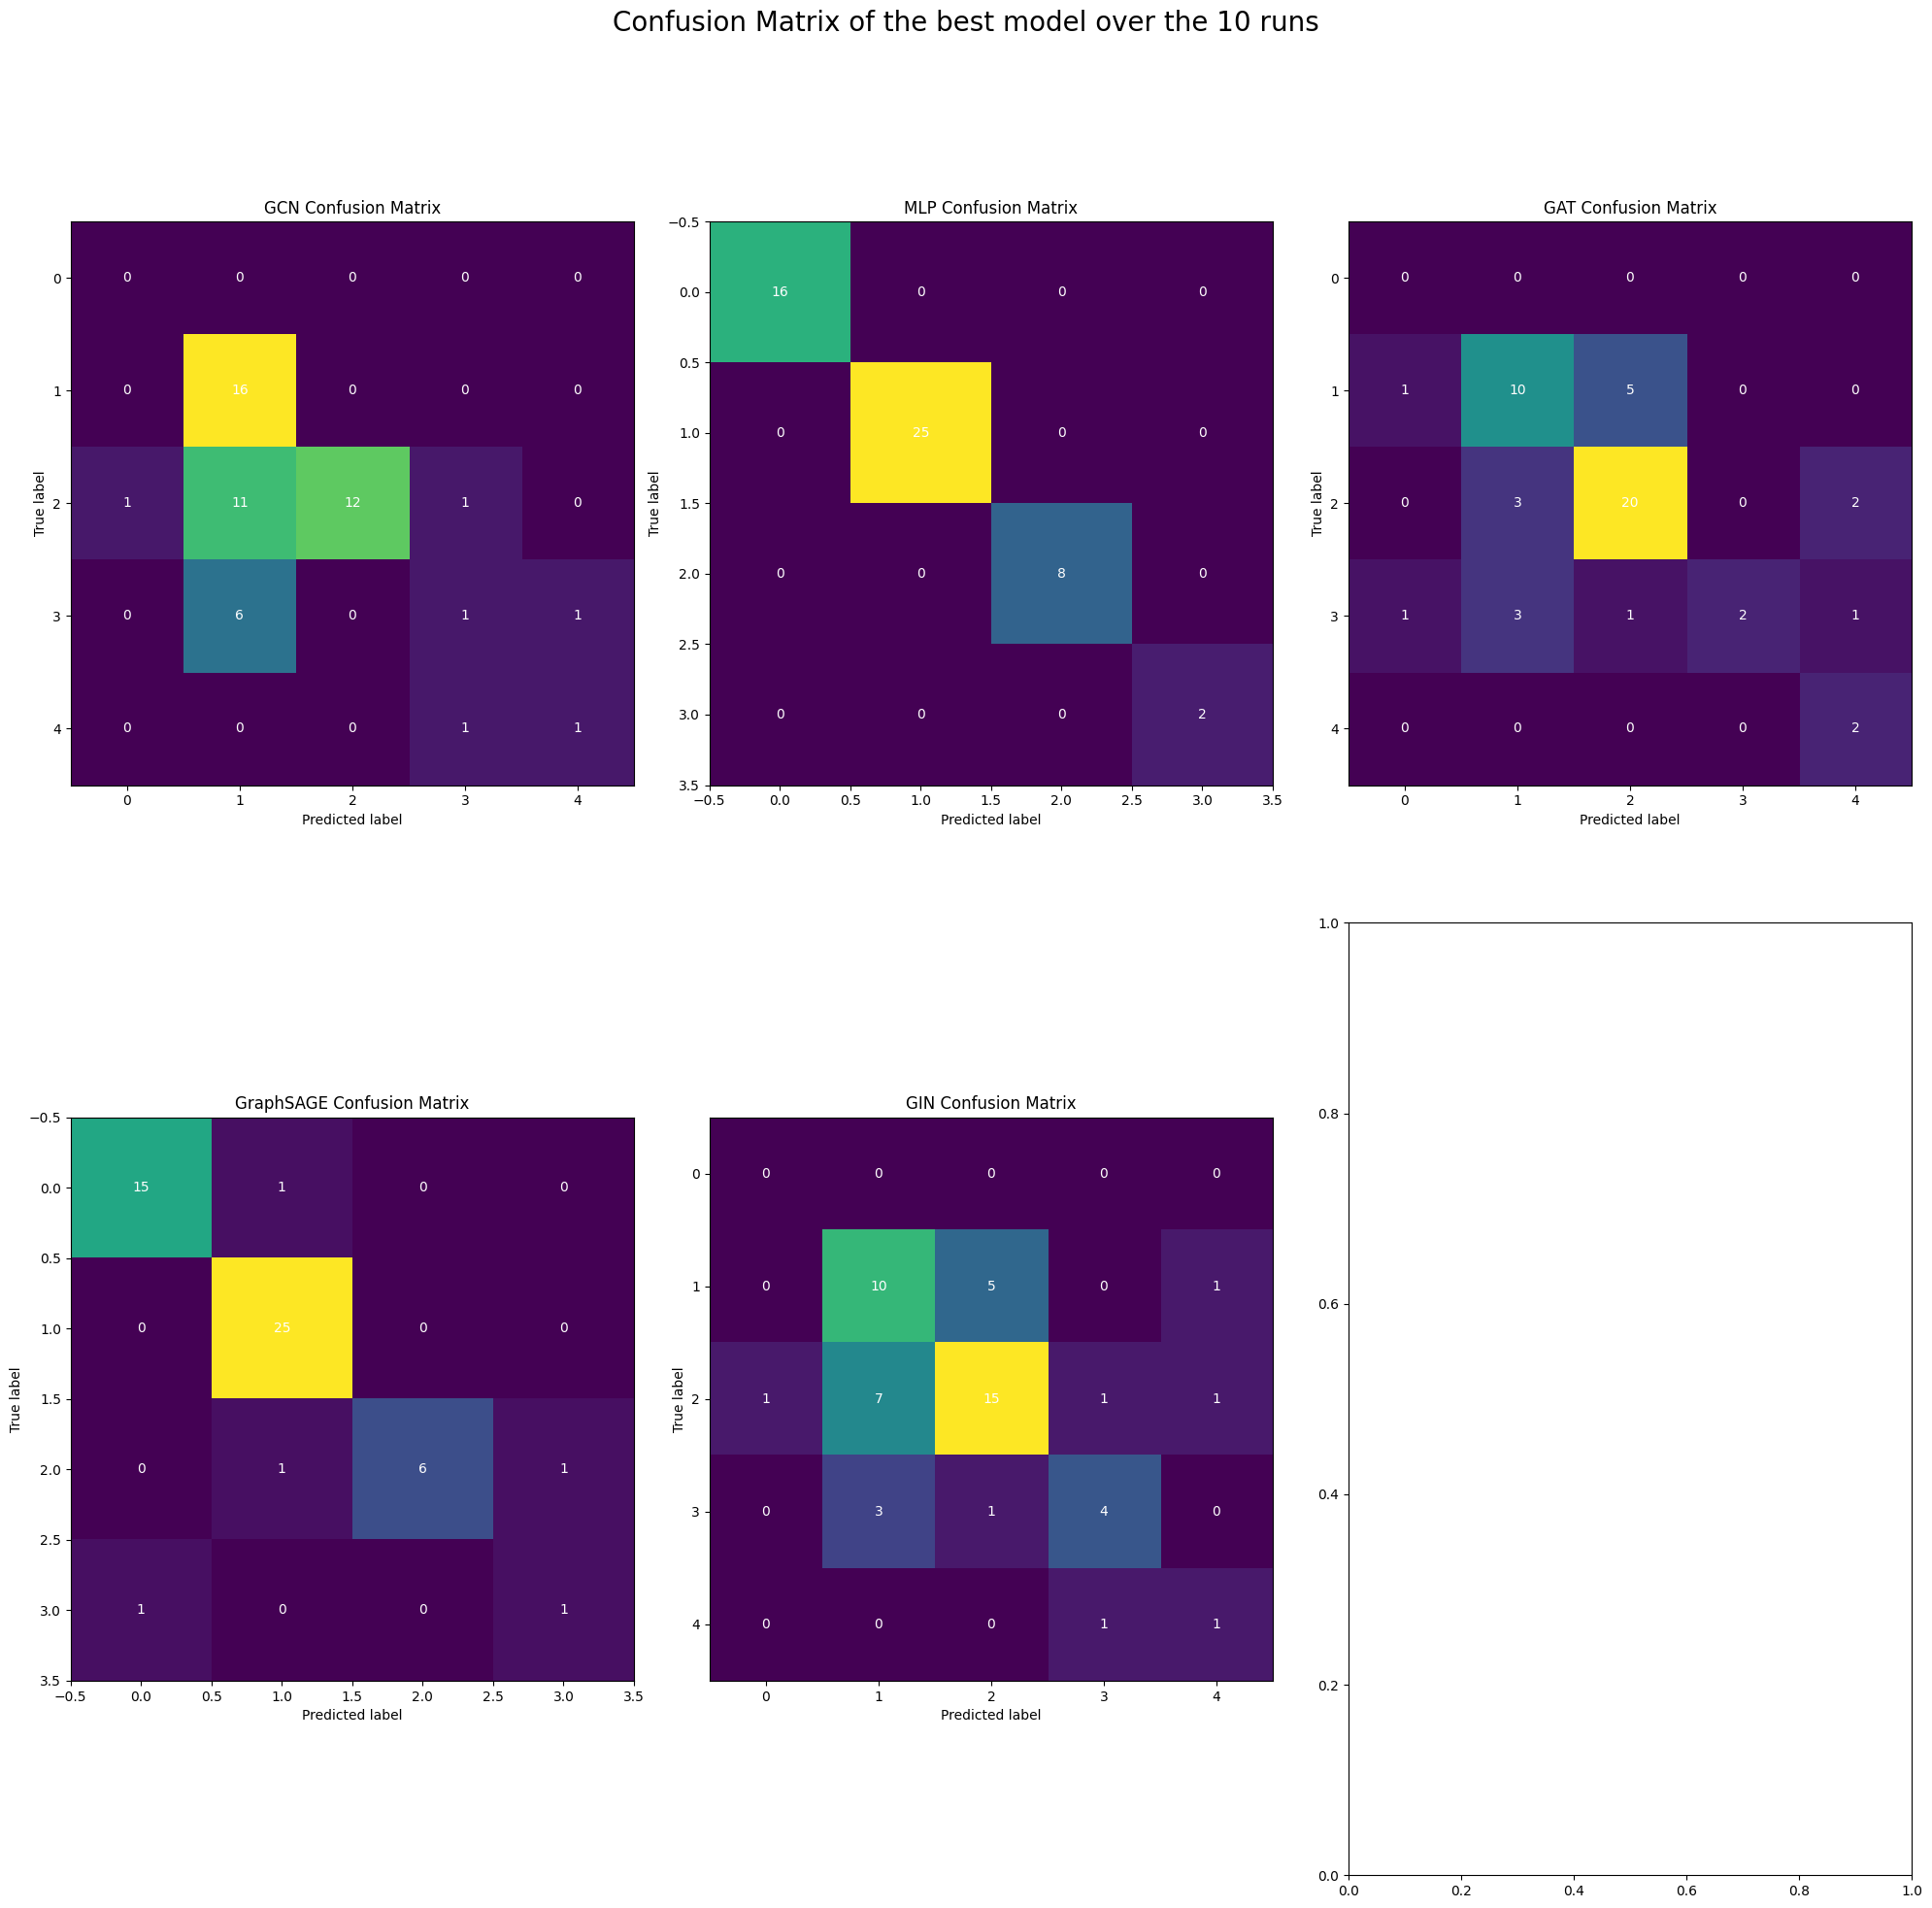

In [26]:
'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, (model, model_name) in enumerate(zip(models, ['GCN', 'MLP', 'GAT', 'GraphSAGE', 'GIN'])):
    conf_matrix = confusion_matrix(data.y[test_mask].cpu(), global_best_models[i][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=data.y.unique().cpu().numpy())

    row_index = i // 3
    col_index = i % 3

    disp.plot(ax=axs[row_index, col_index])
    disp.ax_.set_title(f'{model_name} Confusion Matrix')
    disp.ax_.set_xlabel('Predicted label')
    disp.ax_.set_ylabel('True label')
    disp.im_.colorbar.remove()

fig.suptitle('Confusion Matrix of the best model over the 10 runs', fontsize=20)
plt.tight_layout()
plt.show()
'''

# Otra estrategia por que daba error esta
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, (model, model_name) in enumerate(zip(models, ['GCN', 'MLP', 'GAT', 'GraphSAGE', 'GIN'])):
    conf_matrix = confusion_matrix(data.y[test_mask].cpu(), global_best_models[i][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())

    row_index = i // 3
    col_index = i % 3

    axs[row_index, col_index].imshow(conf_matrix, cmap='viridis', interpolation='nearest')
    axs[row_index, col_index].set_title(f'{model_name} Confusion Matrix')
    axs[row_index, col_index].set_xlabel('Predicted label')
    axs[row_index, col_index].set_ylabel('True label')

    # Adding text annotations
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            axs[row_index, col_index].text(j, i, conf_matrix[i, j], ha='center', va='center', color='white')

fig.suptitle('Confusion Matrix of the best model over the 10 runs', fontsize=20)
plt.tight_layout()
plt.show()


## Basic Models Results: Scores

In [17]:
# Report the best model over the 10 runs using the test set and sklearn classification report
from sklearn.metrics import classification_report
print('GCN')
print(classification_report(data.y[test_mask].cpu(), global_best_models[0][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('MLP')
print(classification_report(data.y[test_mask].cpu(), global_best_models[1][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GAT')
print(classification_report(data.y[test_mask].cpu(), global_best_models[2][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GraphSAGE')
print(classification_report(data.y[test_mask].cpu(), global_best_models[3][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GIN')
print(classification_report(data.y[test_mask].cpu(), global_best_models[4][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

GCN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.48      1.00      0.65        16
           2       1.00      0.48      0.65        25
           3       0.33      0.12      0.18         8
           4       0.50      0.50      0.50         2

    accuracy                           0.59        51
   macro avg       0.46      0.42      0.40        51
weighted avg       0.71      0.59      0.57        51

MLP
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         2

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51

GAT
              precision    recall  f1-score   support

         

## Complex Models Training

In [18]:
# Seeds for the random split. This allows us to reproduce the results.
RandList = [12345, 423456, 643451, 543452, 743456, 4734510, 654321, 124321, 945321, 784328]
# This allows us to run the code on the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Here you can add models to train and test (include your own models)
models2 = [GCN2(), MLP2(), GAT2(), GraphSAGE2(), GIN2()]
global_results2 = []
global_best_models2 = []

cuda


In [19]:
for j in range(len(models2)):
    ExperimentResult2 = []
    best_model2 = None
    #print(data)
    for i in range(10):
        #print("Random State", RandList[i]," in the iteration",i)
        train_mask,test_mask,val_mask = get_semi_supervised_split(data.cpu(), RandList[i])
        #train_mask,test_mask,val_mask = get_supervised_split(data.cpu(), RandList[i])
        data = data.to(device)
        model = models2[j].to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        for epoch in range(1, 101):
            loss, acc_train = train(model,data,optimizer,train_mask.to(device),device=device)
            acc_validation = validation(model,data,val_mask.to(device),device=device)
            #print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Val Acc: {:.5f}'.format(epoch, loss, acc_train, acc_validation))
        acc = test(model,data,test_mask.to(device),device=device)
        #print('Test Accuracy: {:.5f}'.format(acc))
        # Save the best model over the 10 runs
        if best_model2 is None or acc > best_model2[1]:
            best_model2 = [model, acc]
        ExperimentResult2.append(acc)
        del model
    print(models2[j].__class__.__name__) # Name of the model
    print('{} +- {}'.format(np.mean(ExperimentResult2)*100, np.std(ExperimentResult2)*100))
    global_results2.append(ExperimentResult2.copy())
    global_best_models2.append(best_model2.copy())

GCN2
48.823529411764696 +- 8.788601894515676
MLP2
87.84313725490195 +- 6.550311015094143
GAT2
46.07843137254902 +- 6.806492140278346
GraphSAGE2
73.92156862745098 +- 12.948601553803183
GIN2
46.666666666666664 +- 8.803899733585745


## Complex Models Results: Visualization

### Boxplot and Lineplot

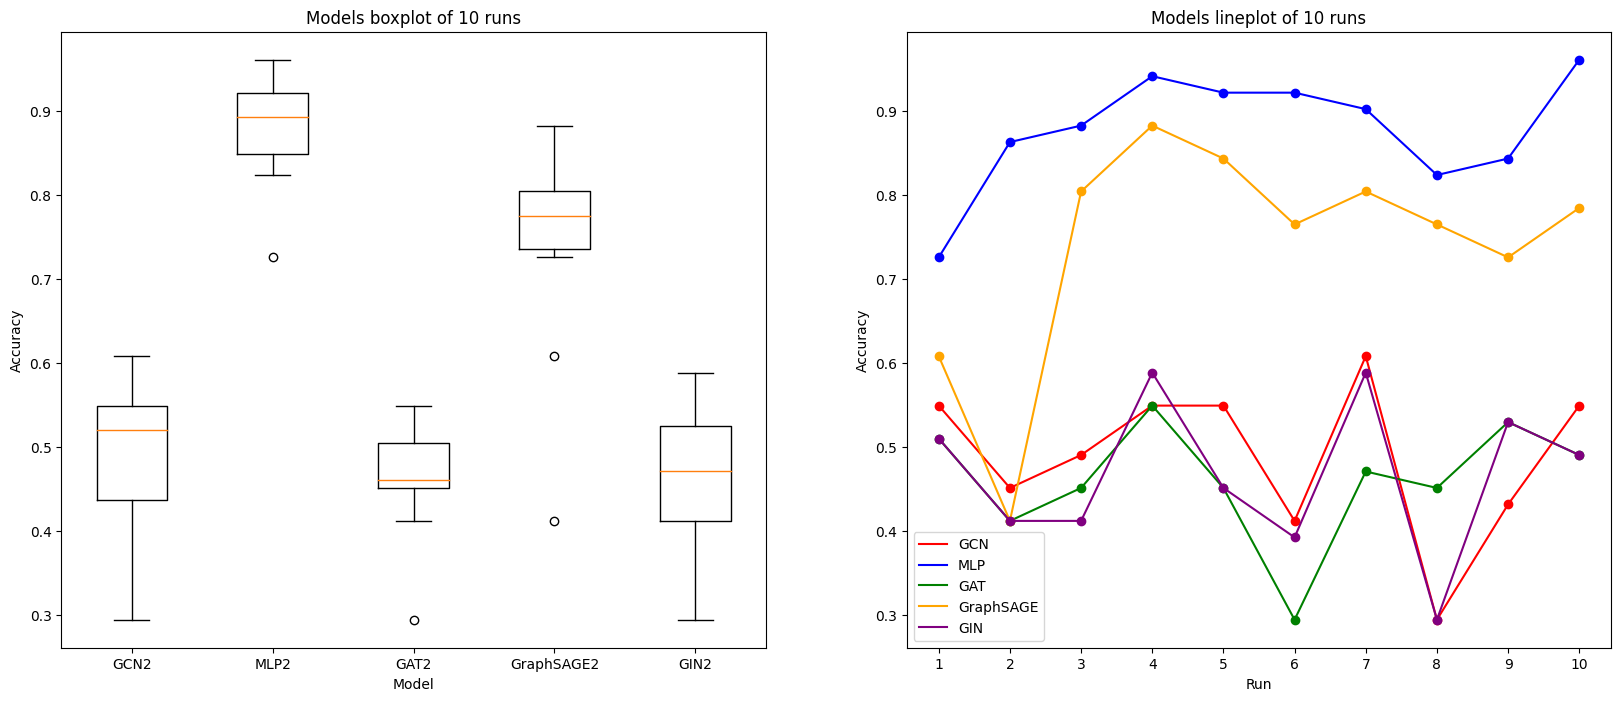

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Boxplot
axs[0].set_title('Models boxplot of 10 runs')
axs[0].boxplot(global_results2, labels=['GCN2', 'MLP2', 'GAT2', 'GraphSAGE2', 'GIN2'])
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Accuracy')

# Lineplot
axs[1].set_title('Models lineplot of 10 runs')

# Plotting each model's results
colors = ['red', 'blue', 'green', 'orange', 'purple']
labels = ['GCN', 'MLP', 'GAT', 'GraphSAGE', 'GIN']
for i, model_results in enumerate(global_results2):
    axs[1].plot(range(1, 11), model_results, 'ro', color=colors[i])
    axs[1].plot(range(1, 11), model_results, color=colors[i], label=labels[i])

axs[1].set_xticks(range(1, 11))
axs[1].set_xlabel('Run')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()


### t-SNE

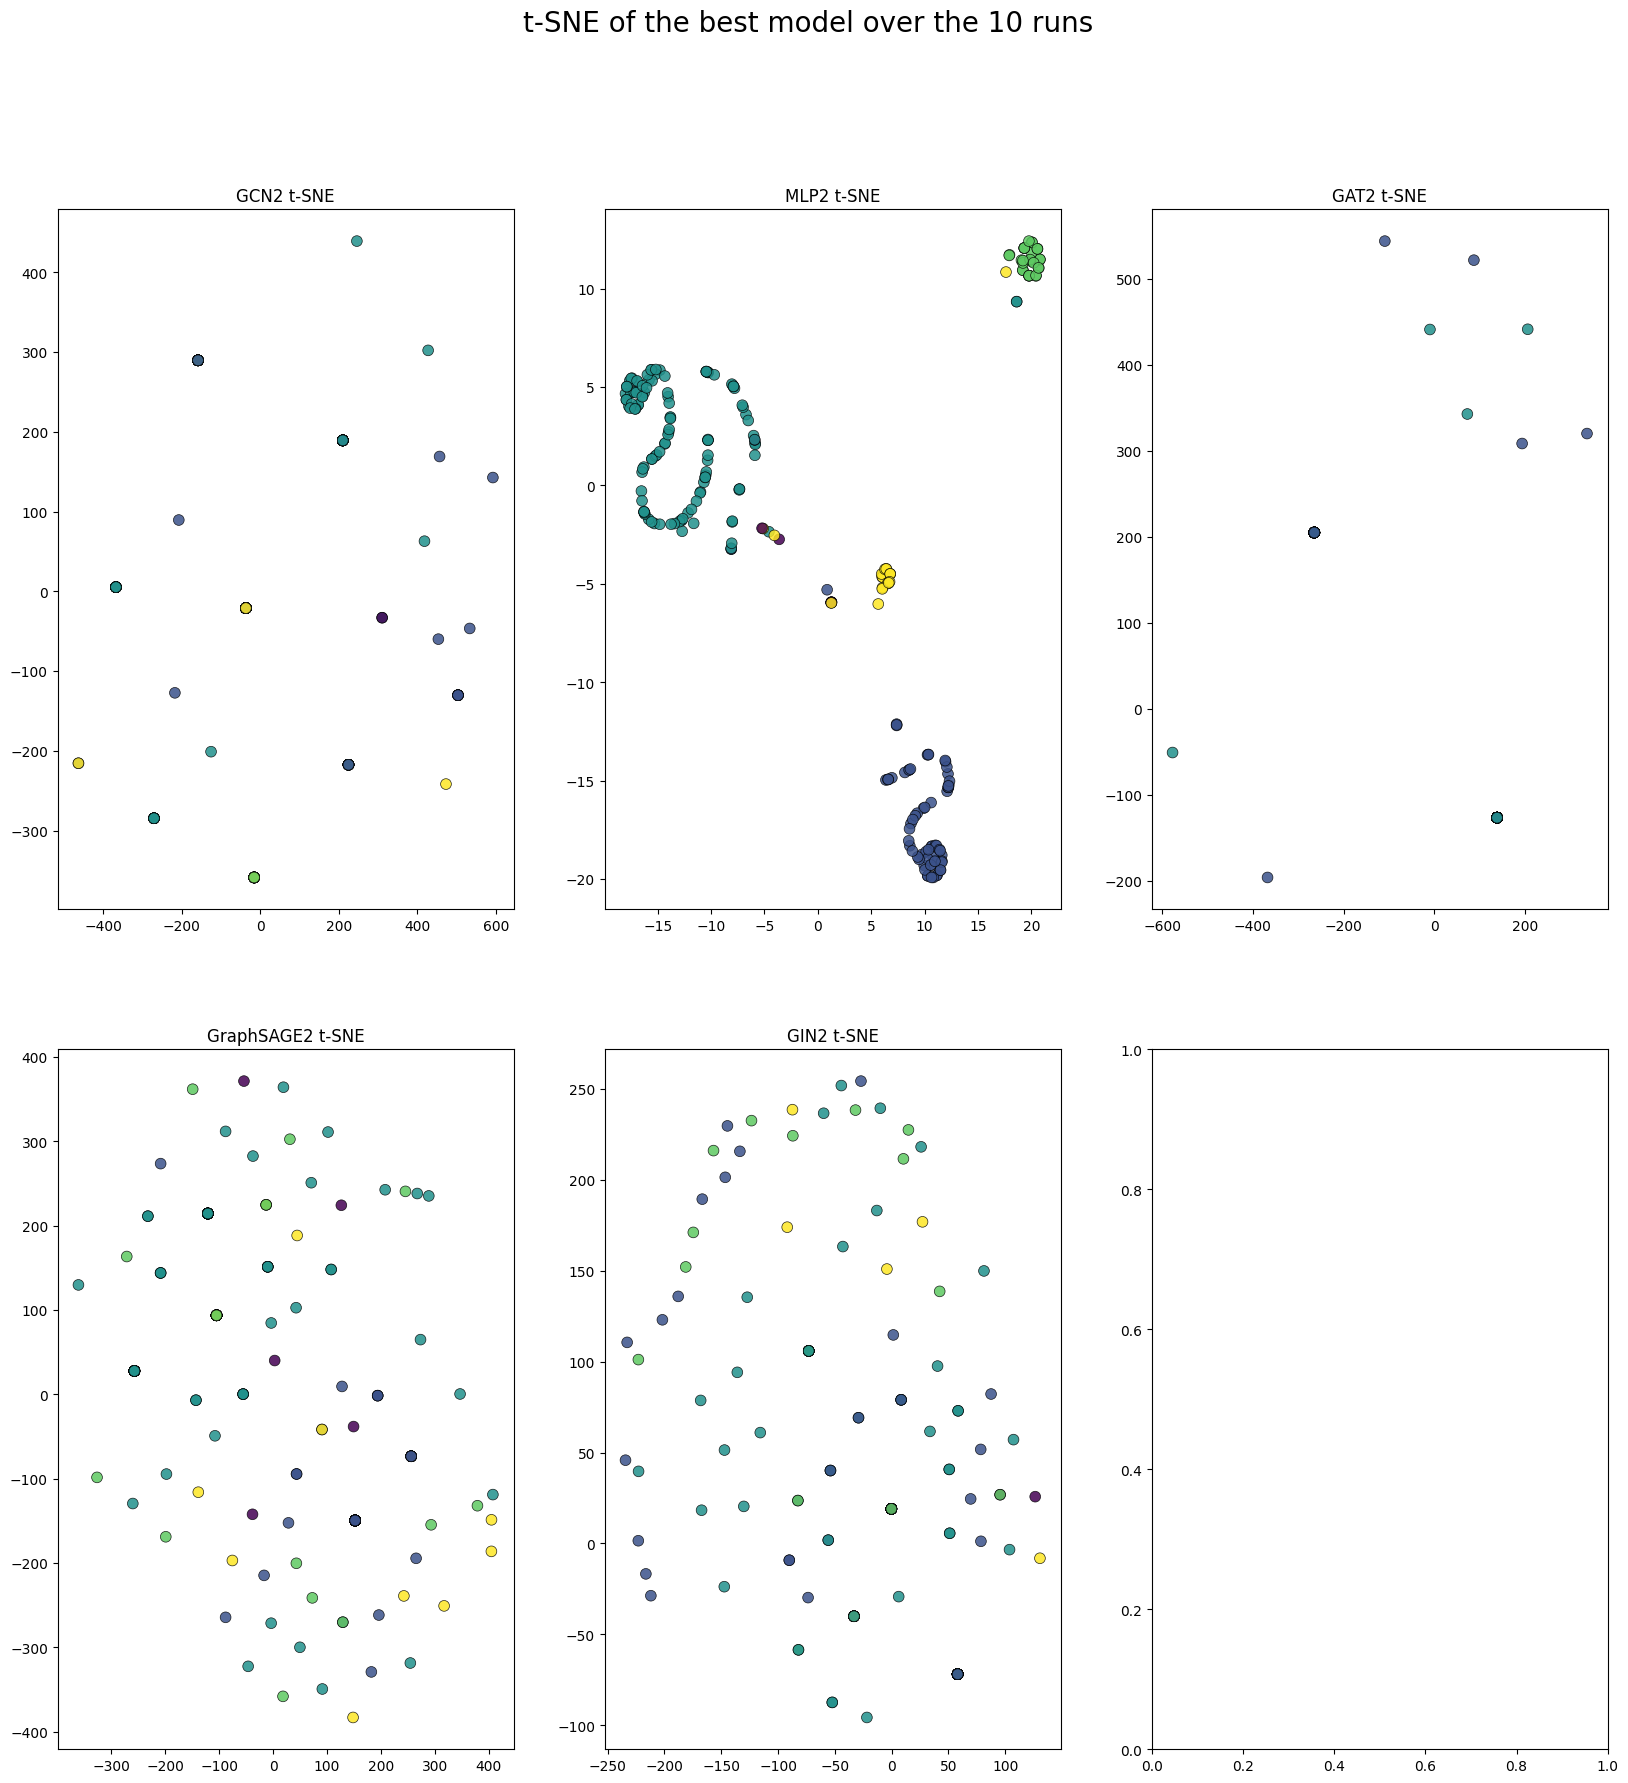

In [21]:
from sklearn.manifold import TSNE

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

# Para recorrer los subplots
subplot_index = 0

for i, (model, model_name) in enumerate(zip(models2, ['GCN2', 'MLP2', 'GAT2', 'GraphSAGE2', 'GIN2'])):
    out_model = global_best_models2[i][0](data.x, data.edge_index)
    tsne = TSNE(n_components=2, random_state=12345)
    tsne_results = tsne.fit_transform(out_model.detach().cpu().numpy())

    row_index = i // 3
    col_index = i % 3

    axs[row_index, col_index].set_title(f'{model_name} t-SNE')
    axs[row_index, col_index].scatter(tsne_results[:, 0], tsne_results[:, 1], c=data.y.cpu(), cmap='viridis', s=60, alpha=0.85, edgecolors='black', linewidths=0.5)
    subplot_index += 1

fig.suptitle('t-SNE of the best model over the 10 runs', fontsize=20)
plt.show()


### Confusion Matrix

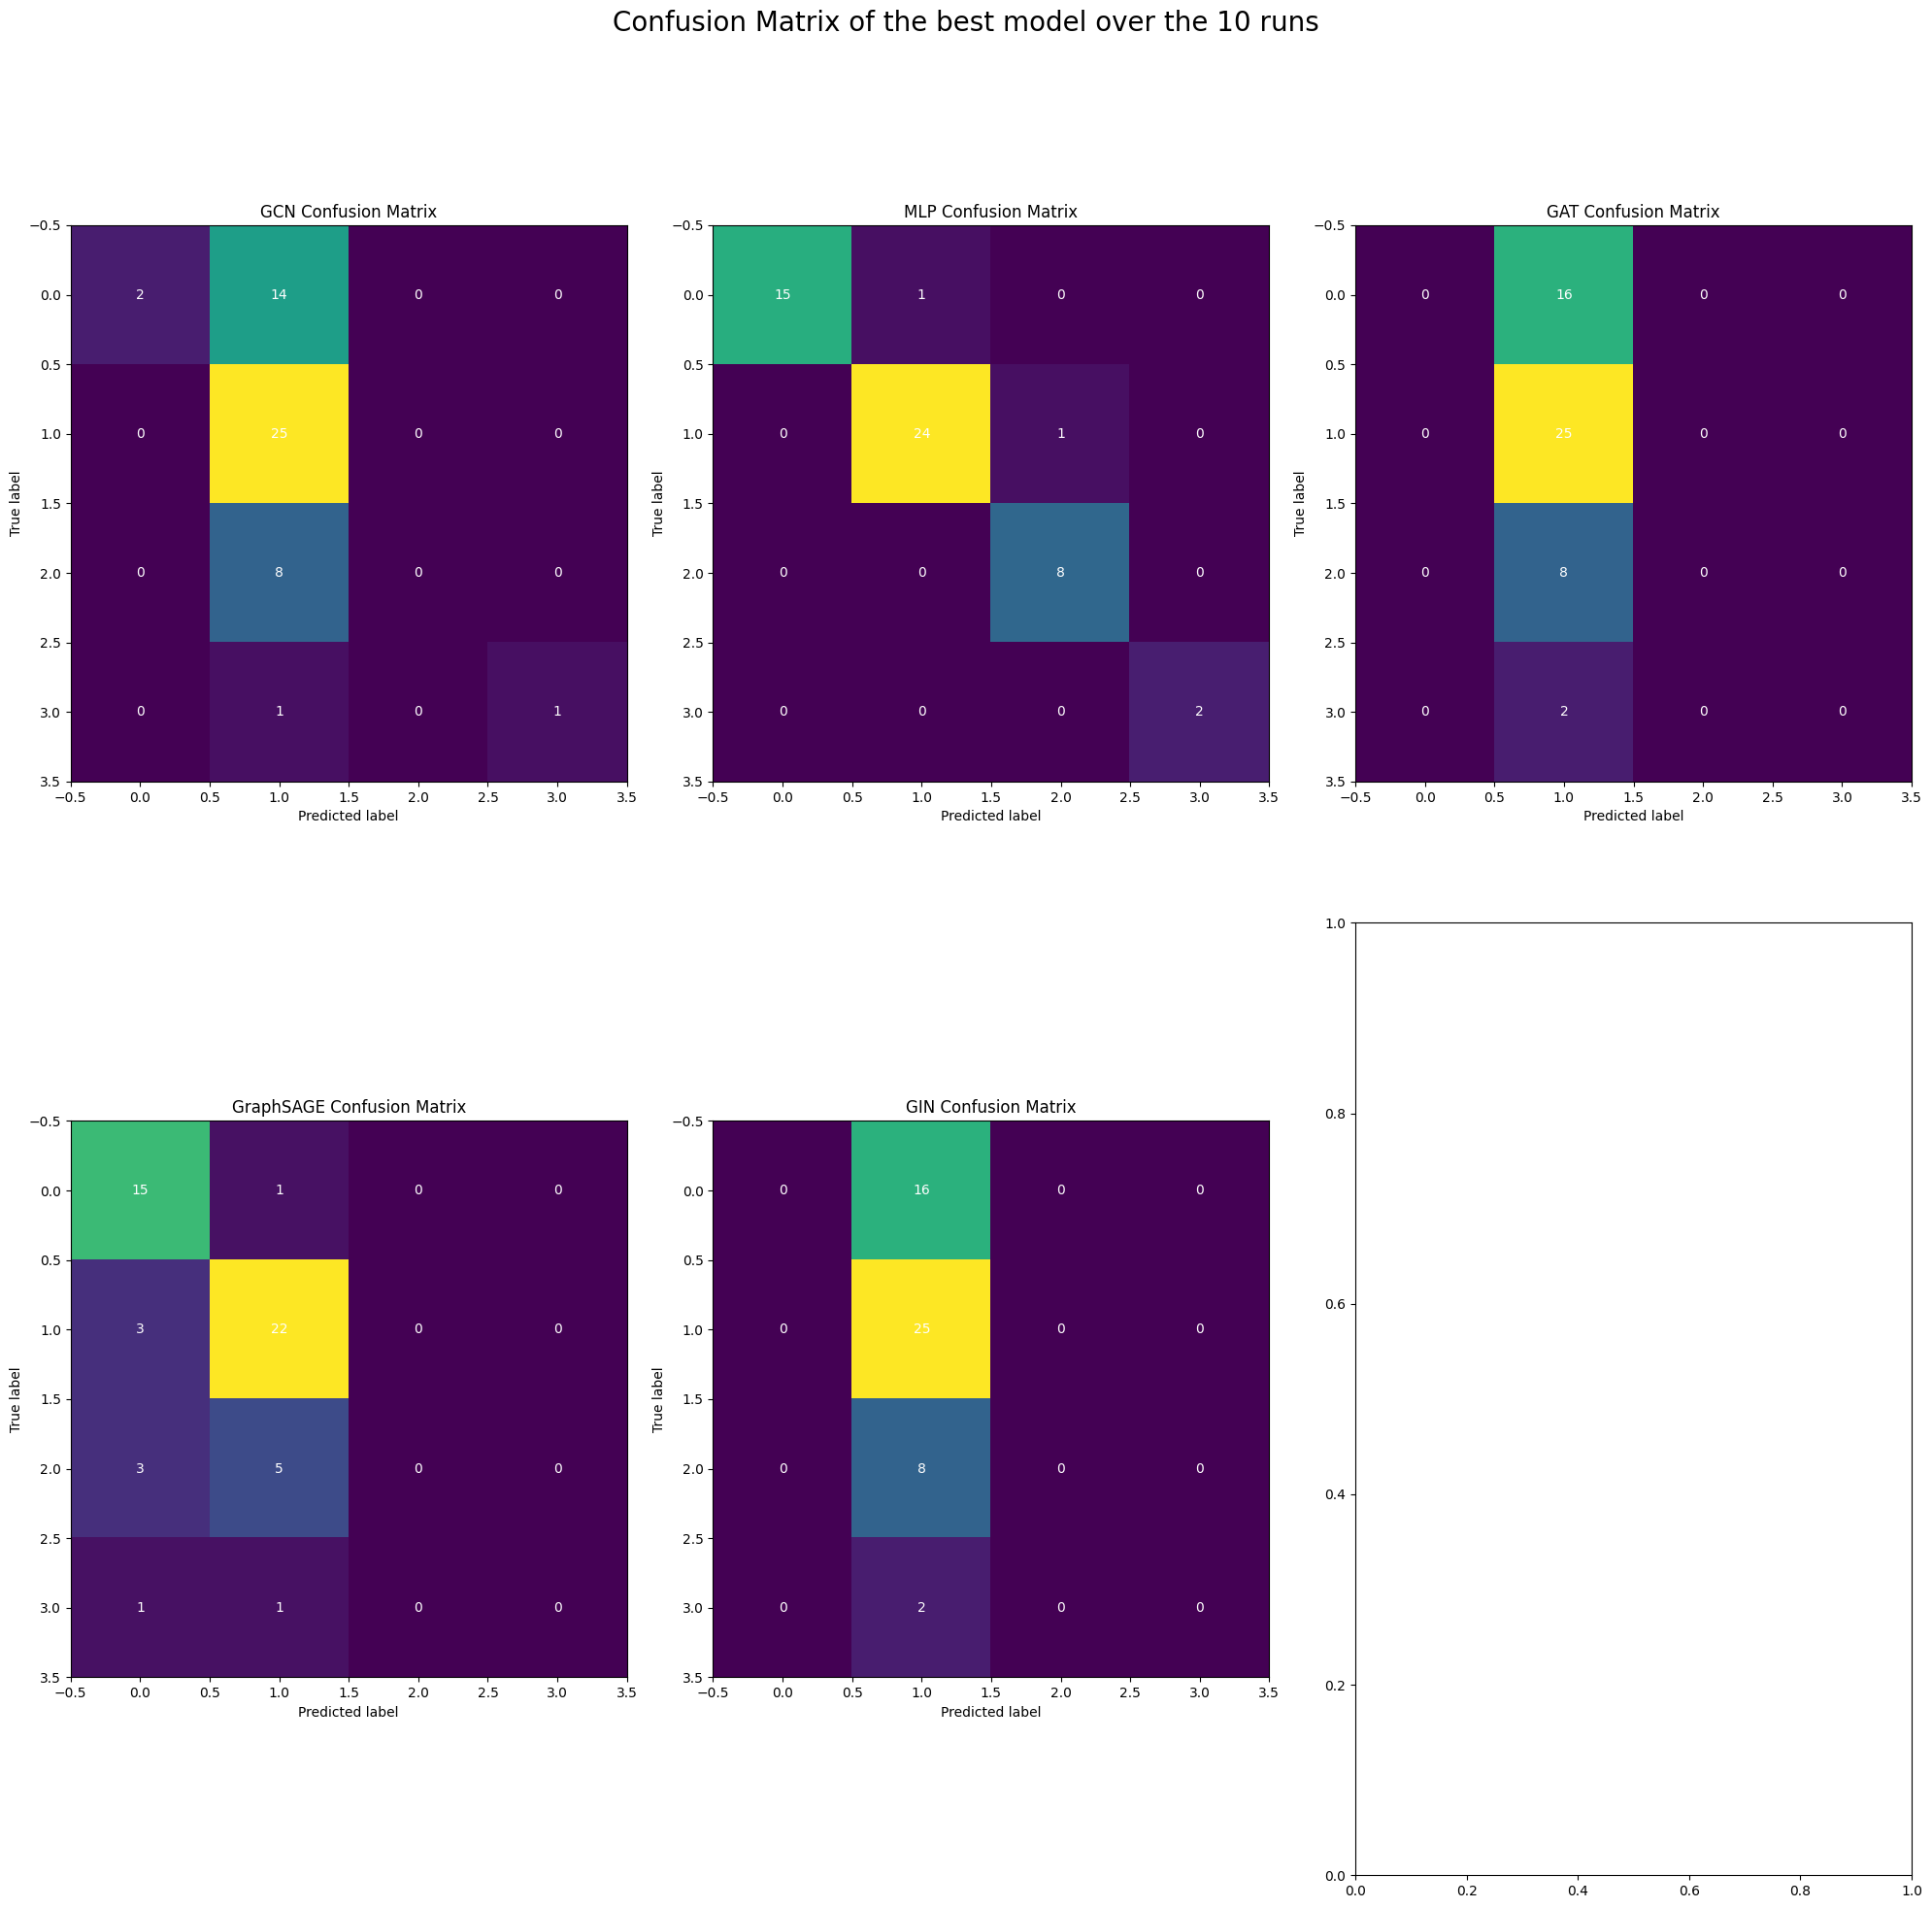

In [28]:
'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, (model, model_name) in enumerate(zip(models2, ['GCN2', 'MLP2', 'GAT2', 'GraphSAGE2', 'GIN2'])):
    conf_matrix = confusion_matrix(data.y[test_mask].cpu(), global_best_models2[i][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=data.y.unique().cpu().numpy())

    row_index = i // 3
    col_index = i % 3

    disp.plot(ax=axs[row_index, col_index])
    disp.ax_.set_title(f'{model_name} Confusion Matrix')
    disp.ax_.set_xlabel('Predicted label')
    disp.ax_.set_ylabel('True label')
    disp.im_.colorbar.remove()

fig.suptitle('Confusion Matrix of the best model over the 10 runs', fontsize=20)
plt.tight_layout()
plt.show()
'''

# Otra estrategia por que daba error esta
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, (model, model_name) in enumerate(zip(models2, ['GCN', 'MLP', 'GAT', 'GraphSAGE', 'GIN'])):
    conf_matrix = confusion_matrix(data.y[test_mask].cpu(), global_best_models2[i][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())

    row_index = i // 3
    col_index = i % 3

    axs[row_index, col_index].imshow(conf_matrix, cmap='viridis', interpolation='nearest')
    axs[row_index, col_index].set_title(f'{model_name} Confusion Matrix')
    axs[row_index, col_index].set_xlabel('Predicted label')
    axs[row_index, col_index].set_ylabel('True label')

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            axs[row_index, col_index].text(j, i, conf_matrix[i, j], ha='center', va='center', color='white')

fig.suptitle('Confusion Matrix of the best model over the 10 runs', fontsize=20)
plt.tight_layout()
plt.show()

## Complex Models Results: Scores

In [23]:
# Report the best model over the 10 runs using the test set and sklearn classification report
from sklearn.metrics import classification_report
print('GCN2')
print(classification_report(data.y[test_mask].cpu(), global_best_models2[0][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('MLP2')
print(classification_report(data.y[test_mask].cpu(), global_best_models2[1][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GAT2')
print(classification_report(data.y[test_mask].cpu(), global_best_models2[2][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GraphSAGE2')
print(classification_report(data.y[test_mask].cpu(), global_best_models2[3][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GIN2')
print(classification_report(data.y[test_mask].cpu(), global_best_models2[4][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

GCN2
              precision    recall  f1-score   support

           1       1.00      0.12      0.22        16
           2       0.52      1.00      0.68        25
           3       0.00      0.00      0.00         8
           4       1.00      0.50      0.67         2

    accuracy                           0.55        51
   macro avg       0.63      0.41      0.39        51
weighted avg       0.61      0.55      0.43        51

MLP2
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        16
           2       0.96      0.96      0.96        25
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         2

    accuracy                           0.96        51
   macro avg       0.96      0.97      0.97        51
weighted avg       0.96      0.96      0.96        51

GAT2
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
      

## Basic Models (Spectral Layer)

In [12]:
import torch
from torch.nn import Sequential, Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, GATv2Conv

class GCN3(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super(GCN3, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = ChebConv(hidden_channels, dataset.num_classes, K=OUT_CHANNELS)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index)) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1) 

print(GCN3())


class MLP3(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super(MLP3, self).__init__()
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = ChebConv(hidden_channels, dataset.num_classes, K=OUT_CHANNELS)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x, edge_index)
        return x.softmax(dim=1)

print(MLP3())


class GAT3(torch.nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS, num_heads=8):
        super(GAT3, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=num_heads)
        self.conv2 = ChebConv(hidden_channels * num_heads, out_channels, K=OUT_CHANNELS)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1)
    
print(GAT3())



class GraphSAGE3(torch.nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS):
        super(GraphSAGE3, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = ChebConv(hidden_channels, out_channels, K=OUT_CHANNELS)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.softmax(dim=1)

print(GraphSAGE3())


class GIN3(torch.nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS):
        super(GIN3, self).__init__()
        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels)))
        self.conv2 = ChebConv(hidden_channels, out_channels, K=OUT_CHANNELS)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=1)

print(GIN3())


GCN3(
  (conv1): GCNConv(1703, 16)
  (conv2): ChebConv(16, 5, K=5, normalization=sym)
)
MLP3(
  (lin1): Linear(in_features=1703, out_features=16, bias=True)
  (lin2): ChebConv(16, 5, K=5, normalization=sym)
)
GAT3(
  (conv1): GATv2Conv(1703, 16, heads=8)
  (conv2): ChebConv(128, 5, K=5, normalization=sym)
)
GraphSAGE3(
  (conv1): SAGEConv(1703, 16, aggr=mean)
  (conv2): ChebConv(16, 5, K=5, normalization=sym)
)
GIN3(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1703, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (conv2): ChebConv(16, 5, K=5, normalization=sym)
)


## Basic Models (Spectral Layer) Training

In [13]:
# Seeds for the random split. This allows us to reproduce the results.
RandList = [12345, 423456, 643451, 543452, 743456, 4734510, 654321, 124321, 945321, 784328]
# This allows us to run the code on the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Here you can add models to train and test (include your own models)
models3 = [GCN3(), MLP3(), GAT3(), GraphSAGE3(), GIN3()]
global_results3 = []
global_best_models3 = []

cpu


In [14]:
for j in range(len(models3)):
    ExperimentResult3 = []
    best_model3 = None
    #print(data)
    for i in range(10):
        #print("Random State", RandList[i]," in the iteration",i)
        train_mask,test_mask,val_mask = get_semi_supervised_split(data.cpu(), RandList[i])
        #train_mask,test_mask,val_mask = get_supervised_split(data.cpu(), RandList[i])
        data = data.to(device)
        model = models3[j].to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        for epoch in range(1, 101):
            loss, acc_train = train(model,data,optimizer,train_mask.to(device),device=device)
            acc_validation = validation(model,data,val_mask.to(device),device=device)
            #print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Val Acc: {:.5f}'.format(epoch, loss, acc_train, acc_validation))
        acc = test(model,data,test_mask.to(device),device=device)
        #print('Test Accuracy: {:.5f}'.format(acc))
        # Save the best model over the 10 runs
        if best_model3 is None or acc > best_model3[1]:
            best_model3 = [model, acc]
        ExperimentResult3.append(acc)
        del model
    print(models3[j].__class__.__name__) # Name of the model
    print('{} +- {}'.format(np.mean(ExperimentResult3)*100, np.std(ExperimentResult3)*100))
    global_results3.append(ExperimentResult3.copy())
    global_best_models3.append(best_model3.copy())

GCN3
78.82352941176471 +- 7.326094781282119
MLP3
88.03921568627452 +- 5.645560803485477
GAT3
80.58823529411765 +- 6.0403614904899445
GraphSAGE3
88.43137254901961 +- 5.780158028621047
GIN3
80.0 +- 7.734542322869026


## Basic Models (Spectral Layer) Results: Visualization

### Boxplot and Lineplot

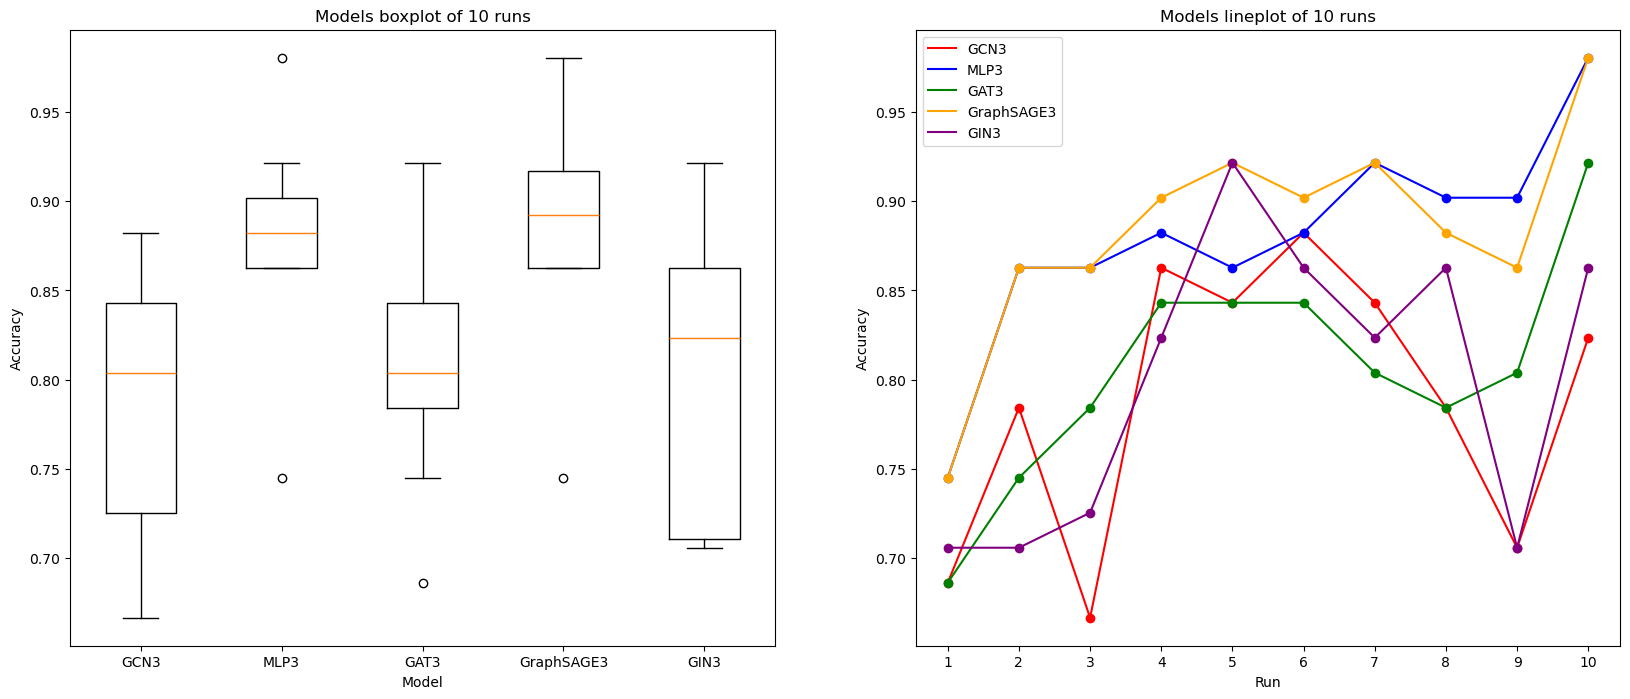

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Boxplot
axs[0].set_title('Models boxplot of 10 runs')
axs[0].boxplot(global_results3, labels=['GCN3', 'MLP3', 'GAT3', 'GraphSAGE3', 'GIN3'])
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Accuracy')

# Lineplot
axs[1].set_title('Models lineplot of 10 runs')

# Plotting each model's results
colors = ['red', 'blue', 'green', 'orange', 'purple']
labels = ['GCN3', 'MLP3', 'GAT3', 'GraphSAGE3', 'GIN3']
for i, model_results in enumerate(global_results3):
    axs[1].plot(range(1, 11), model_results, 'ro', color=colors[i])
    axs[1].plot(range(1, 11), model_results, color=colors[i], label=labels[i])

axs[1].set_xticks(range(1, 11))
axs[1].set_xlabel('Run')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

### t-SNE

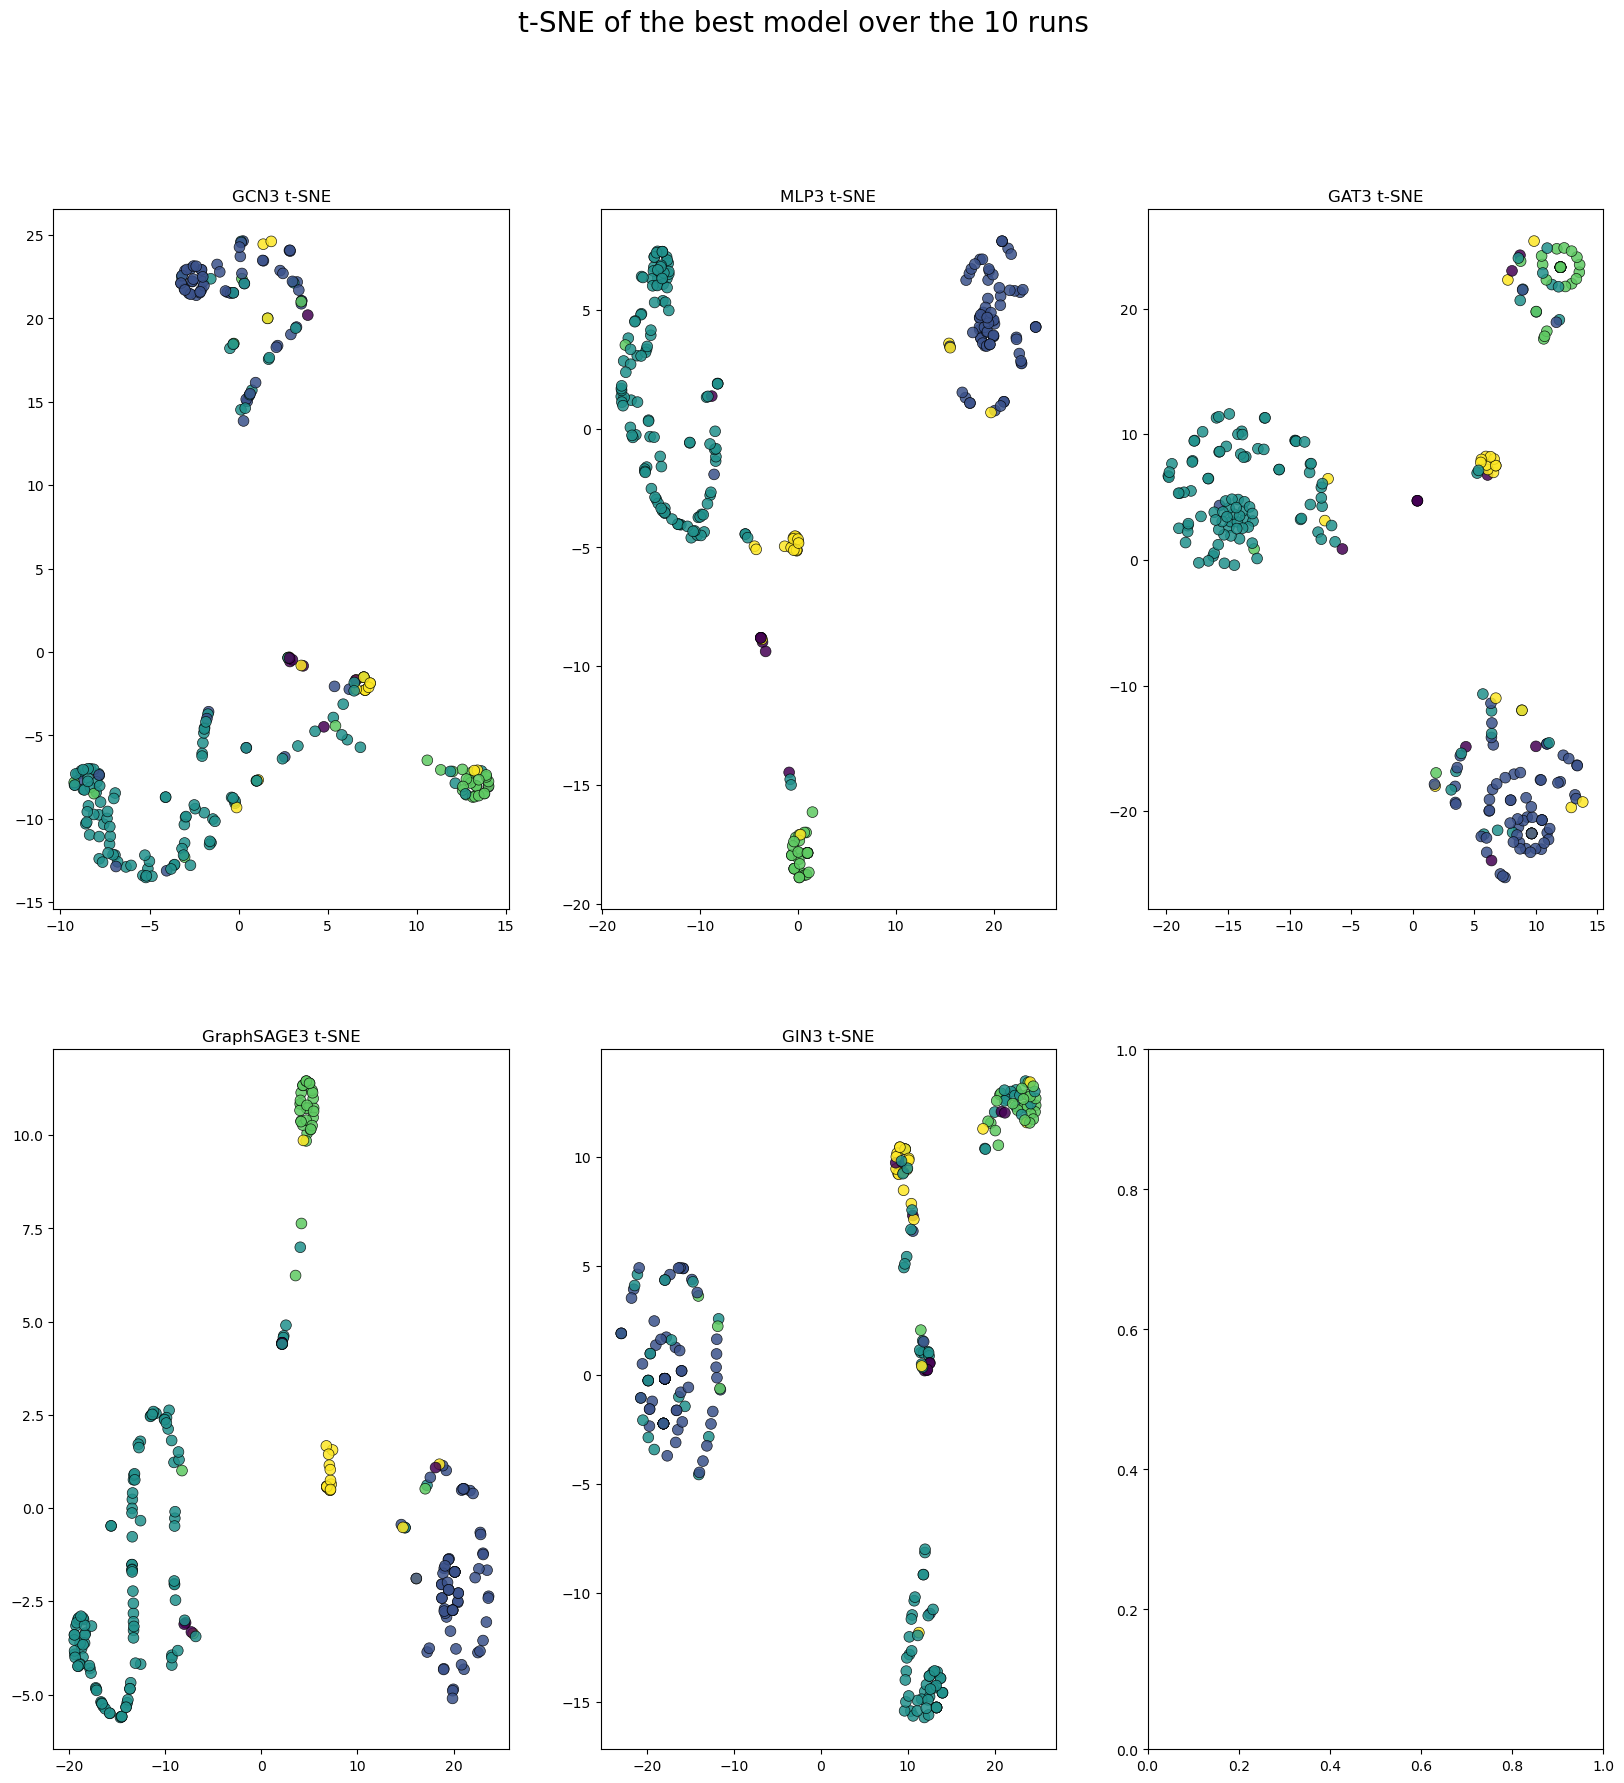

In [16]:
from sklearn.manifold import TSNE

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

# Para recorrer los subplots
subplot_index = 0

for i, (model, model_name) in enumerate(zip(models3, ['GCN3', 'MLP3', 'GAT3', 'GraphSAGE3', 'GIN3'])):
    out_model = global_best_models3[i][0](data.x, data.edge_index)
    tsne = TSNE(n_components=2, random_state=12345)
    tsne_results = tsne.fit_transform(out_model.detach().cpu().numpy())

    row_index = i // 3  
    col_index = i % 3 

    axs[row_index, col_index].set_title(f'{model_name} t-SNE')
    axs[row_index, col_index].scatter(tsne_results[:, 0], tsne_results[:, 1], c=data.y.cpu(), cmap='viridis', s=60, alpha=0.85, edgecolors='black', linewidths=0.5)
    subplot_index += 1

fig.suptitle('t-SNE of the best model over the 10 runs', fontsize=20)
plt.show()


### Confusion Matrix

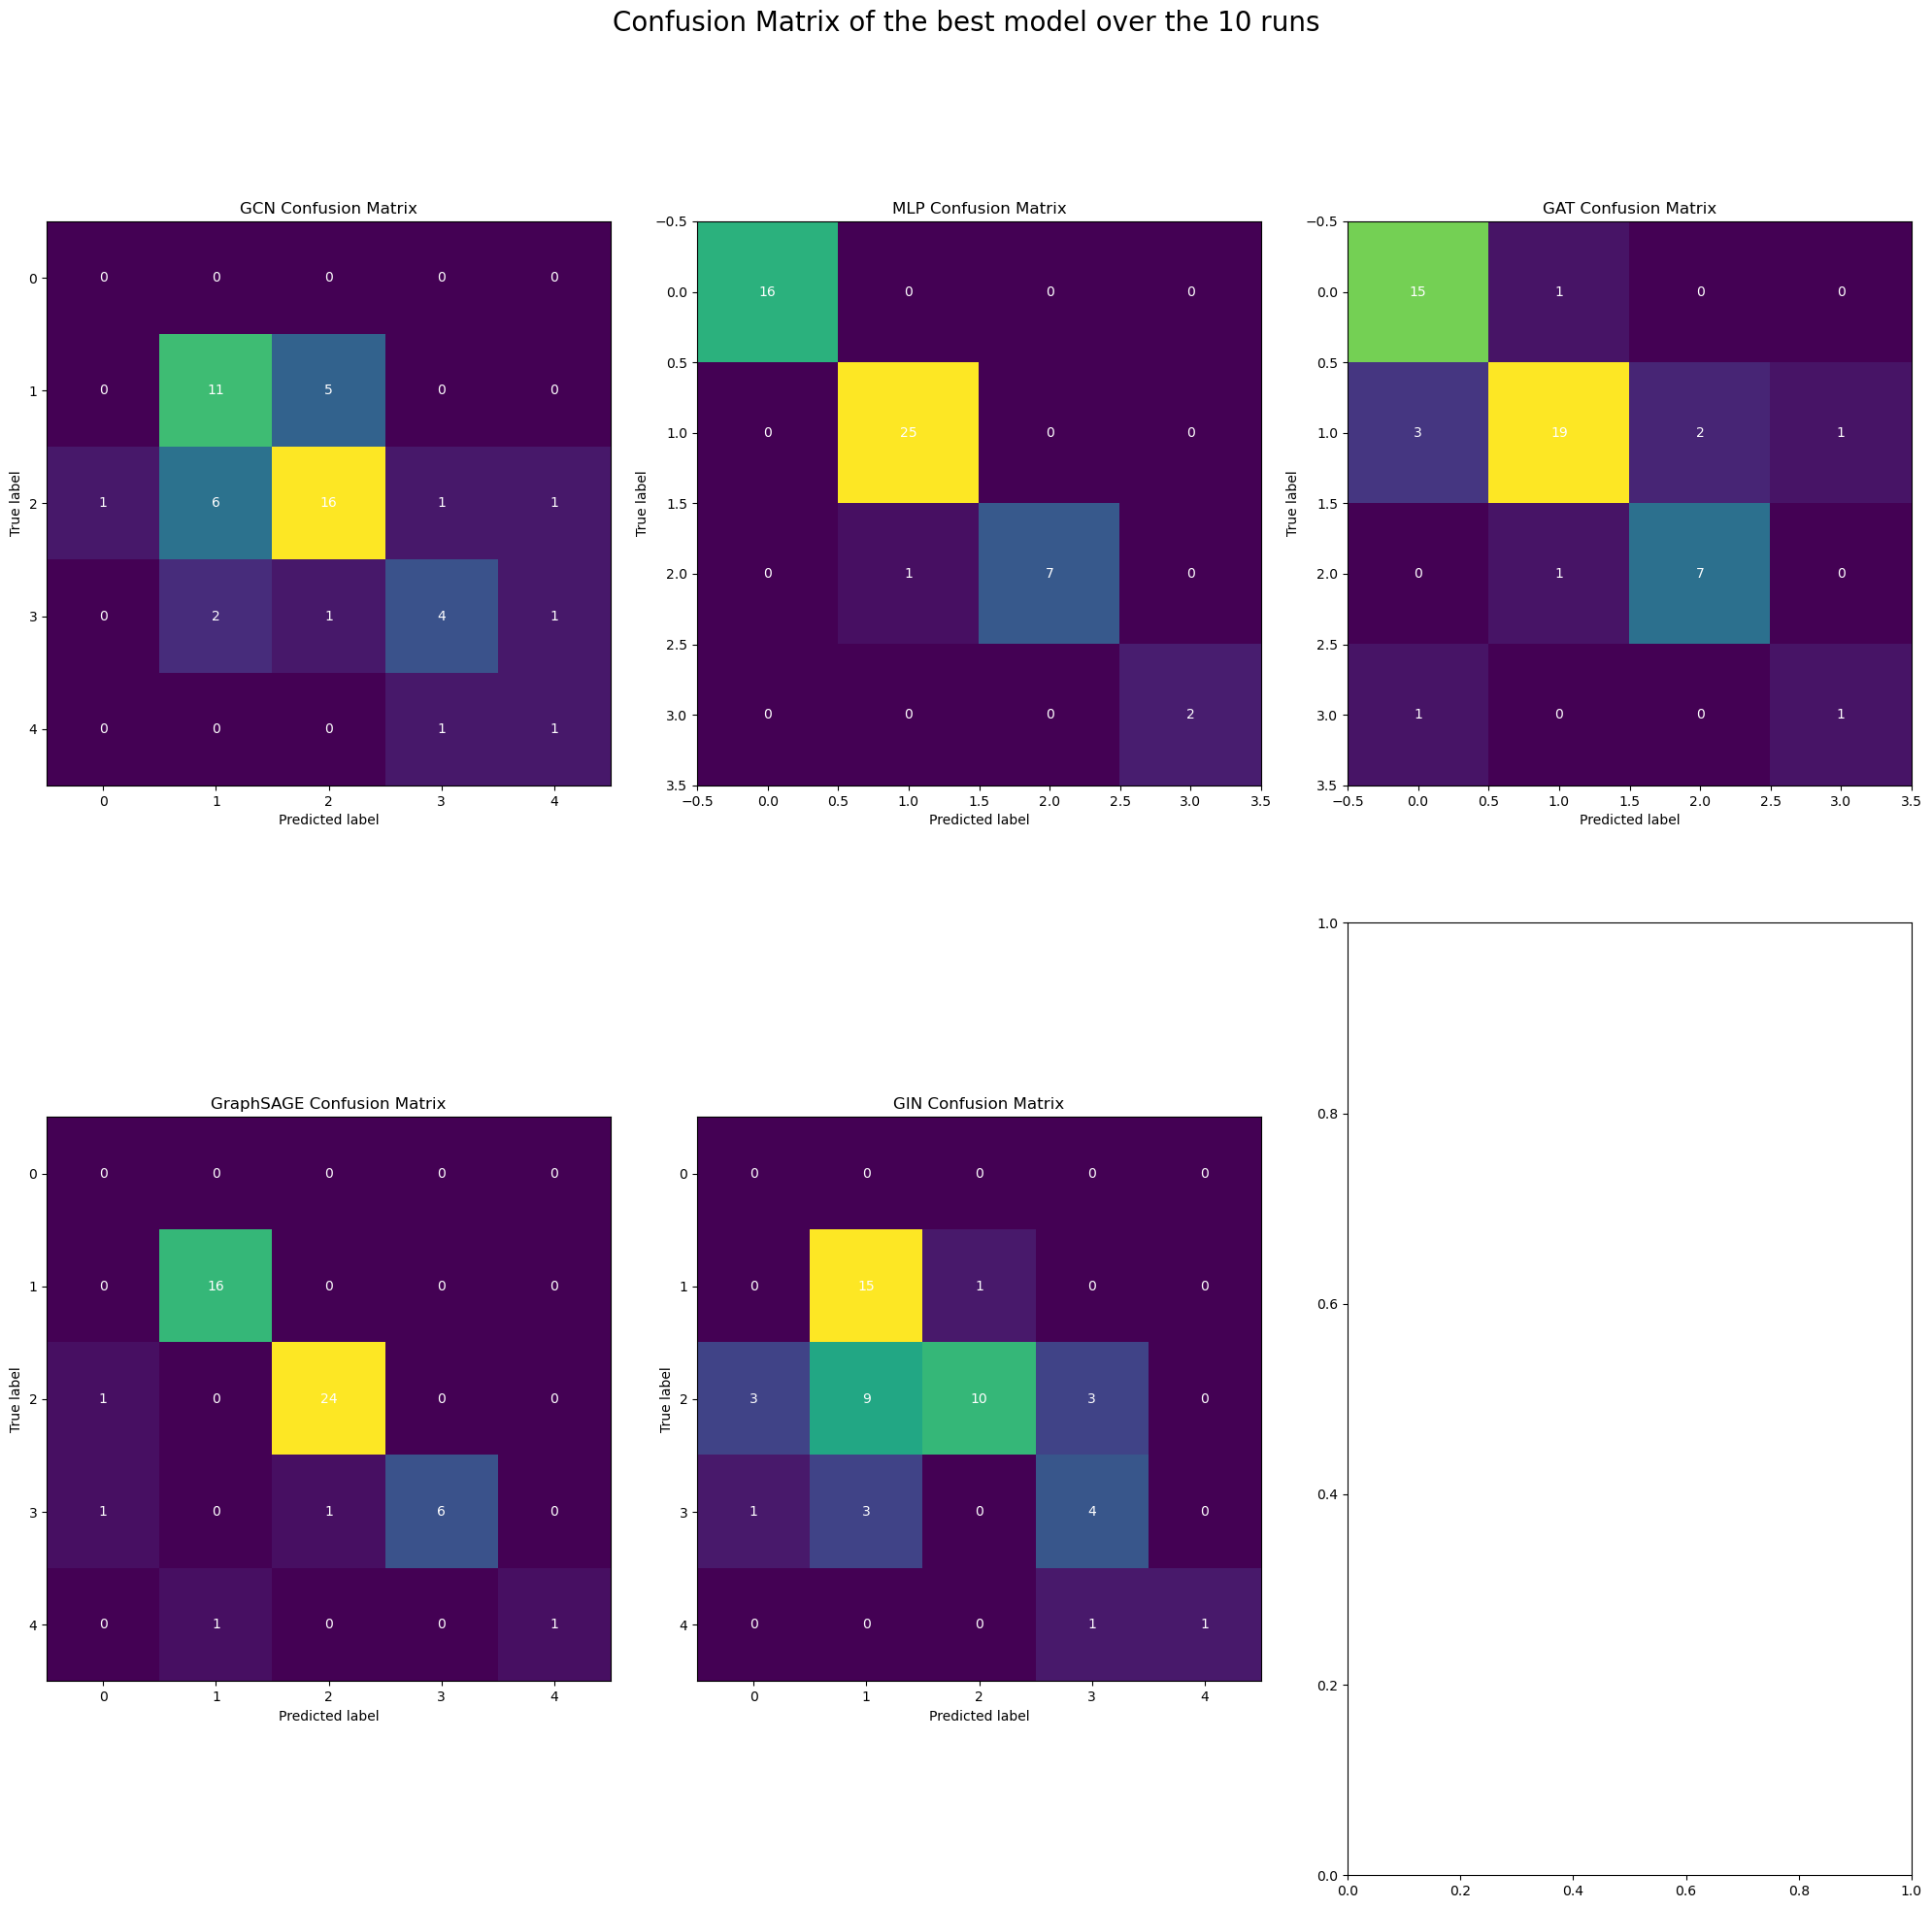

In [18]:
'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, (model, model_name) in enumerate(zip(models3, ['GCN3', 'MLP3', 'GAT3', 'GraphSAGE3', 'GIN3'])):
    conf_matrix = confusion_matrix(data.y[test_mask].cpu(), global_best_models3[i][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=data.y.unique().cpu().numpy())

    row_index = i // 3  
    col_index = i % 3  

    disp.plot(ax=axs[row_index, col_index])
    disp.ax_.set_title(f'{model_name} Confusion Matrix')
    disp.ax_.set_xlabel('Predicted label')
    disp.ax_.set_ylabel('True label')
    disp.im_.colorbar.remove()

fig.suptitle('Confusion Matrix of the best model over the 10 runs', fontsize=20)
plt.tight_layout()
plt.show()
'''

# Otra estrategia por que daba error esta
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, (model, model_name) in enumerate(zip(models3, ['GCN', 'MLP', 'GAT', 'GraphSAGE', 'GIN'])):
    conf_matrix = confusion_matrix(data.y[test_mask].cpu(), global_best_models3[i][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())

    row_index = i // 3
    col_index = i % 3

    axs[row_index, col_index].imshow(conf_matrix, cmap='viridis', interpolation='nearest')
    axs[row_index, col_index].set_title(f'{model_name} Confusion Matrix')
    axs[row_index, col_index].set_xlabel('Predicted label')
    axs[row_index, col_index].set_ylabel('True label')

    # Adding text annotations
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            axs[row_index, col_index].text(j, i, conf_matrix[i, j], ha='center', va='center', color='white')

fig.suptitle('Confusion Matrix of the best model over the 10 runs', fontsize=20)
plt.tight_layout()
plt.show()

## Basic Models (Spectral Layer) Results: Score

In [19]:
# Report the best model over the 10 runs using the test set and sklearn classification report
from sklearn.metrics import classification_report
print('GCN3')
print(classification_report(data.y[test_mask].cpu(), global_best_models3[0][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('MLP3')
print(classification_report(data.y[test_mask].cpu(), global_best_models3[1][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GAT3')
print(classification_report(data.y[test_mask].cpu(), global_best_models3[2][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GraphSAGE3')
print(classification_report(data.y[test_mask].cpu(), global_best_models3[3][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GIN3')
print(classification_report(data.y[test_mask].cpu(), global_best_models3[4][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

GCN3
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.58      0.69      0.63        16
           2       0.73      0.64      0.68        25
           3       0.67      0.50      0.57         8
           4       0.33      0.50      0.40         2

    accuracy                           0.63        51
   macro avg       0.46      0.47      0.46        51
weighted avg       0.66      0.63      0.64        51

MLP3
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       0.96      1.00      0.98        25
           3       1.00      0.88      0.93         8
           4       1.00      1.00      1.00         2

    accuracy                           0.98        51
   macro avg       0.99      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51

GAT3
              precision    recall  f1-score   support

      

## Basic Models (Spectral Layer without Softmax)

In [20]:
import torch
from torch.nn import Sequential, Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, GATv2Conv

class GCN4(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super(GCN4, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = ChebConv(hidden_channels, dataset.num_classes, K=OUT_CHANNELS)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index)) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

print(GCN4())


class MLP4(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super(MLP4, self).__init__()
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = ChebConv(hidden_channels, dataset.num_classes, K=OUT_CHANNELS)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x, edge_index)
        return x

print(MLP4())


class GAT4(torch.nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS, num_heads=8):
        super(GAT4, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=num_heads)
        self.conv2 = ChebConv(hidden_channels * num_heads, out_channels, K=OUT_CHANNELS)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
print(GAT4())



class GraphSAGE4(torch.nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS):
        super(GraphSAGE4, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = ChebConv(hidden_channels, out_channels, K=OUT_CHANNELS)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

print(GraphSAGE4())


class GIN4(torch.nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS):
        super(GIN4, self).__init__()
        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels)))
        self.conv2 = ChebConv(hidden_channels, out_channels, K=OUT_CHANNELS)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

print(GIN4())


GCN4(
  (conv1): GCNConv(1703, 16)
  (conv2): ChebConv(16, 5, K=5, normalization=sym)
)
MLP4(
  (lin1): Linear(in_features=1703, out_features=16, bias=True)
  (lin2): ChebConv(16, 5, K=5, normalization=sym)
)
GAT4(
  (conv1): GATv2Conv(1703, 16, heads=8)
  (conv2): ChebConv(128, 5, K=5, normalization=sym)
)
GraphSAGE4(
  (conv1): SAGEConv(1703, 16, aggr=mean)
  (conv2): ChebConv(16, 5, K=5, normalization=sym)
)
GIN4(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1703, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (conv2): ChebConv(16, 5, K=5, normalization=sym)
)


## Basic Models (Spectral Layer without Softmax) Training

In [21]:
# Seeds for the random split. This allows us to reproduce the results.
RandList = [12345, 423456, 643451, 543452, 743456, 4734510, 654321, 124321, 945321, 784328]
# This allows us to run the code on the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Here you can add models to train and test (include your own models)
models4 = [GCN4(), MLP4(), GAT4(), GraphSAGE4(), GIN4()]
global_results4 = []
global_best_models4 = []

cpu


In [22]:
for j in range(len(models4)):
    ExperimentResult4 = []
    best_model4 = None
    #print(data)
    for i in range(10):
        #print("Random State", RandList[i]," in the iteration",i)
        train_mask,test_mask,val_mask = get_semi_supervised_split(data.cpu(), RandList[i])
        #train_mask,test_mask,val_mask = get_supervised_split(data.cpu(), RandList[i])
        data = data.to(device)
        model = models4[j].to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        for epoch in range(1, 101):
            loss, acc_train = train(model,data,optimizer,train_mask.to(device),device=device)
            acc_validation = validation(model,data,val_mask.to(device),device=device)
            #print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Val Acc: {:.5f}'.format(epoch, loss, acc_train, acc_validation))
        acc = test(model,data,test_mask.to(device),device=device)
        #print('Test Accuracy: {:.5f}'.format(acc))
        # Save the best model over the 10 runs
        if best_model4 is None or acc > best_model4[1]:
            best_model4 = [model, acc]
        ExperimentResult4.append(acc)
        del model
    print(models4[j].__class__.__name__) # Name of the model
    print('{} +- {}'.format(np.mean(ExperimentResult4)*100, np.std(ExperimentResult4)*100))
    global_results4.append(ExperimentResult4.copy())
    global_best_models4.append(best_model4.copy())

GCN4
78.03921568627452 +- 6.249951941376167
MLP4
92.54901960784314 +- 7.430311890782909
GAT4
84.31372549019606 +- 7.388801443692852
GraphSAGE4
90.58823529411765 +- 6.550311015094142
GIN4
82.35294117647058 +- 9.403591222181802


## Basic Models (Spectral Layer without Softmax) Results: Visualization

### Boxplot and Lineplot

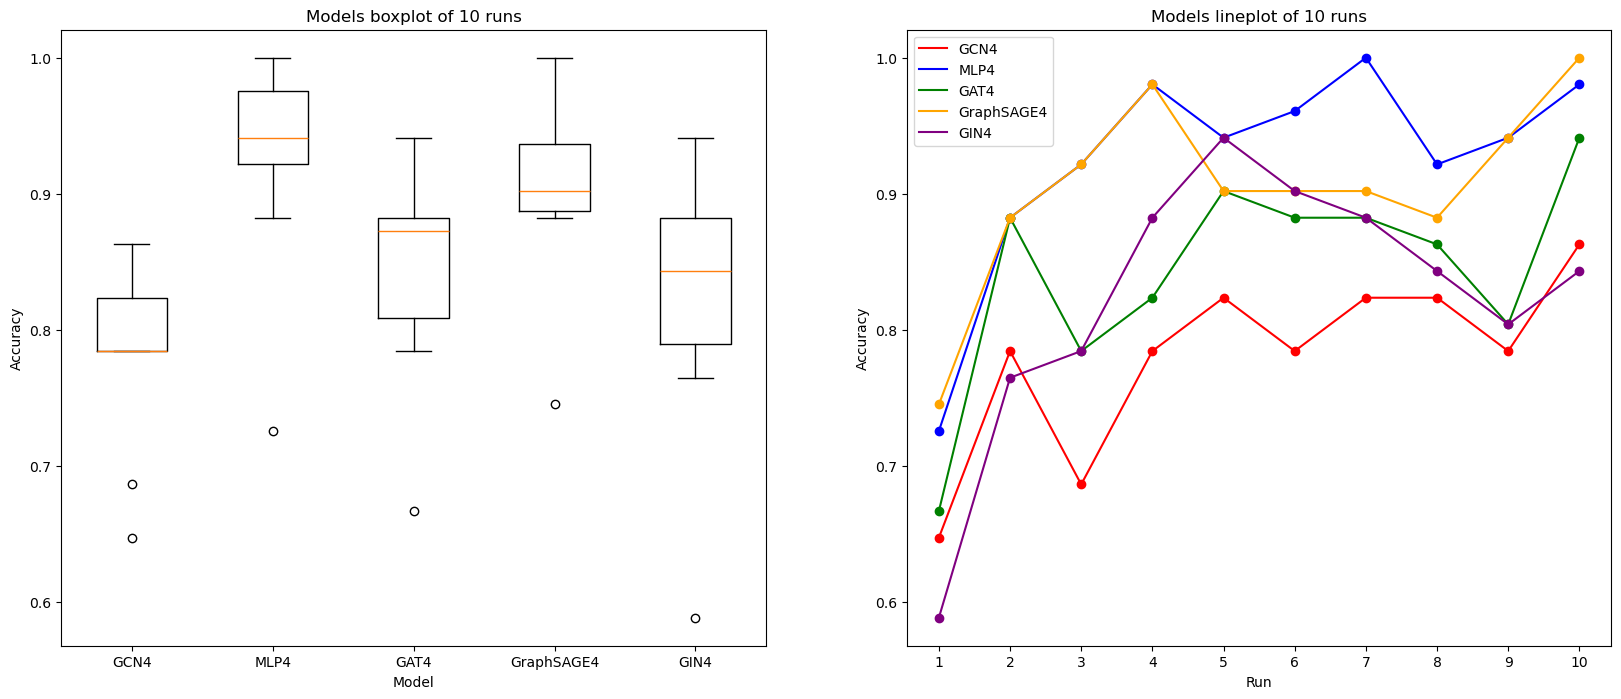

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Boxplot
axs[0].set_title('Models boxplot of 10 runs')
axs[0].boxplot(global_results4, labels=['GCN4', 'MLP4', 'GAT4', 'GraphSAGE4', 'GIN4'])
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Accuracy')

# Lineplot
axs[1].set_title('Models lineplot of 10 runs')

# Plotting each model's results
colors = ['red', 'blue', 'green', 'orange', 'purple']
labels = ['GCN4', 'MLP4', 'GAT4', 'GraphSAGE4', 'GIN4']
for i, model_results in enumerate(global_results4):
    axs[1].plot(range(1, 11), model_results, 'ro', color=colors[i])
    axs[1].plot(range(1, 11), model_results, color=colors[i], label=labels[i])

axs[1].set_xticks(range(1, 11))
axs[1].set_xlabel('Run')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

### t-SNE

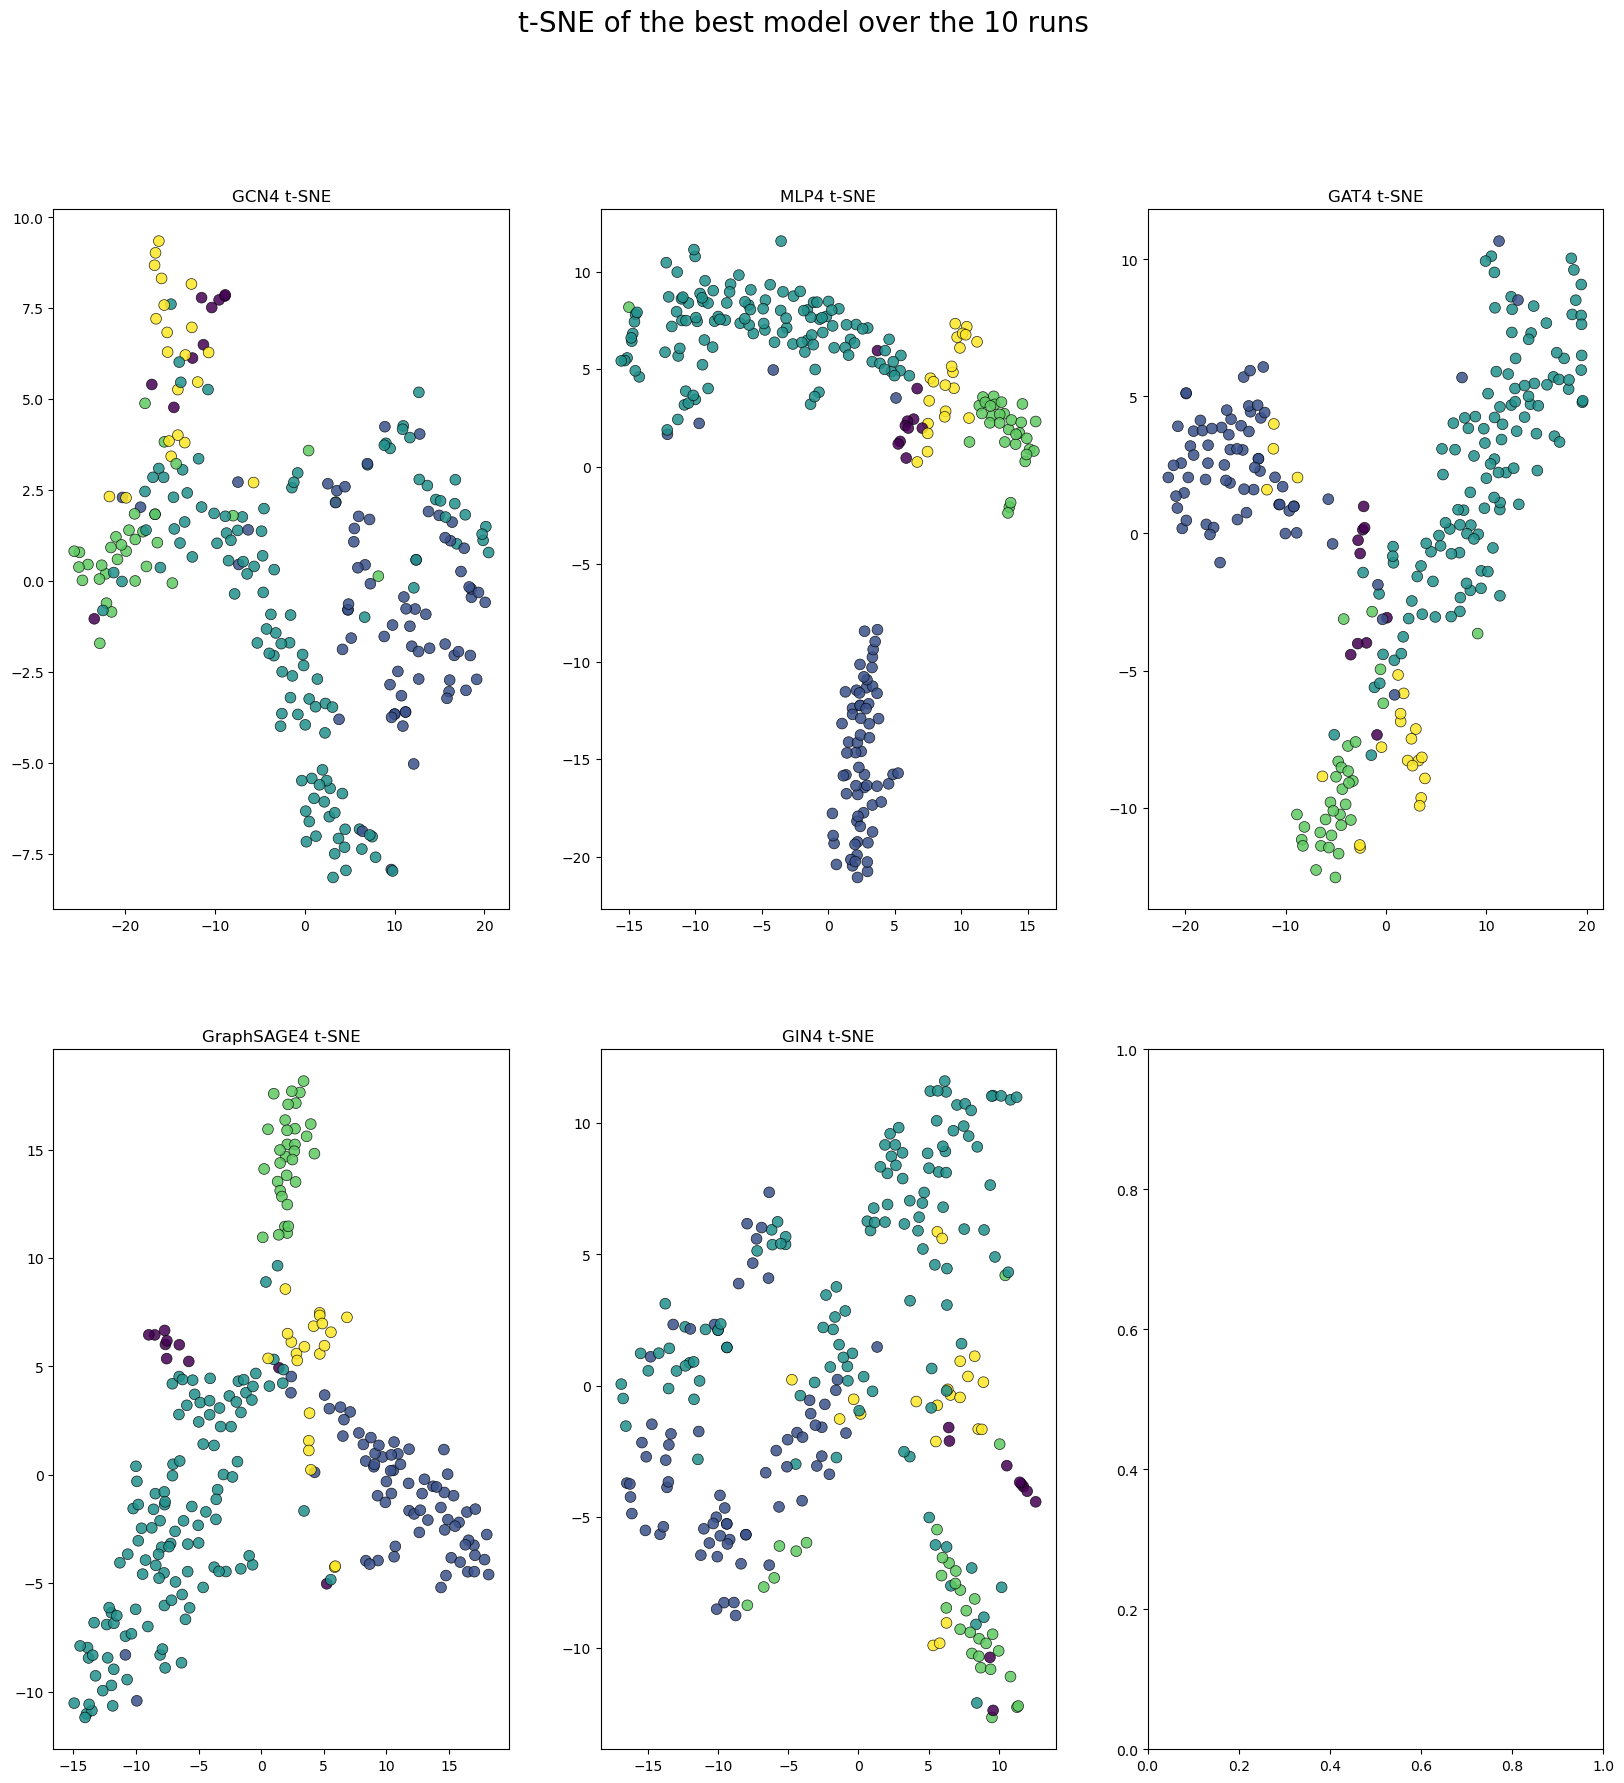

In [24]:
from sklearn.manifold import TSNE

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

# Para recorrer los subplots
subplot_index = 0

for i, (model, model_name) in enumerate(zip(models4, ['GCN4', 'MLP4', 'GAT4', 'GraphSAGE4', 'GIN4'])):
    out_model = global_best_models4[i][0](data.x, data.edge_index)
    tsne = TSNE(n_components=2, random_state=12345)
    tsne_results = tsne.fit_transform(out_model.detach().cpu().numpy())

    row_index = i // 3  
    col_index = i % 3 

    axs[row_index, col_index].set_title(f'{model_name} t-SNE')
    axs[row_index, col_index].scatter(tsne_results[:, 0], tsne_results[:, 1], c=data.y.cpu(), cmap='viridis', s=60, alpha=0.85, edgecolors='black', linewidths=0.5)
    subplot_index += 1

fig.suptitle('t-SNE of the best model over the 10 runs', fontsize=20)
plt.show()


### Confusion Matrix

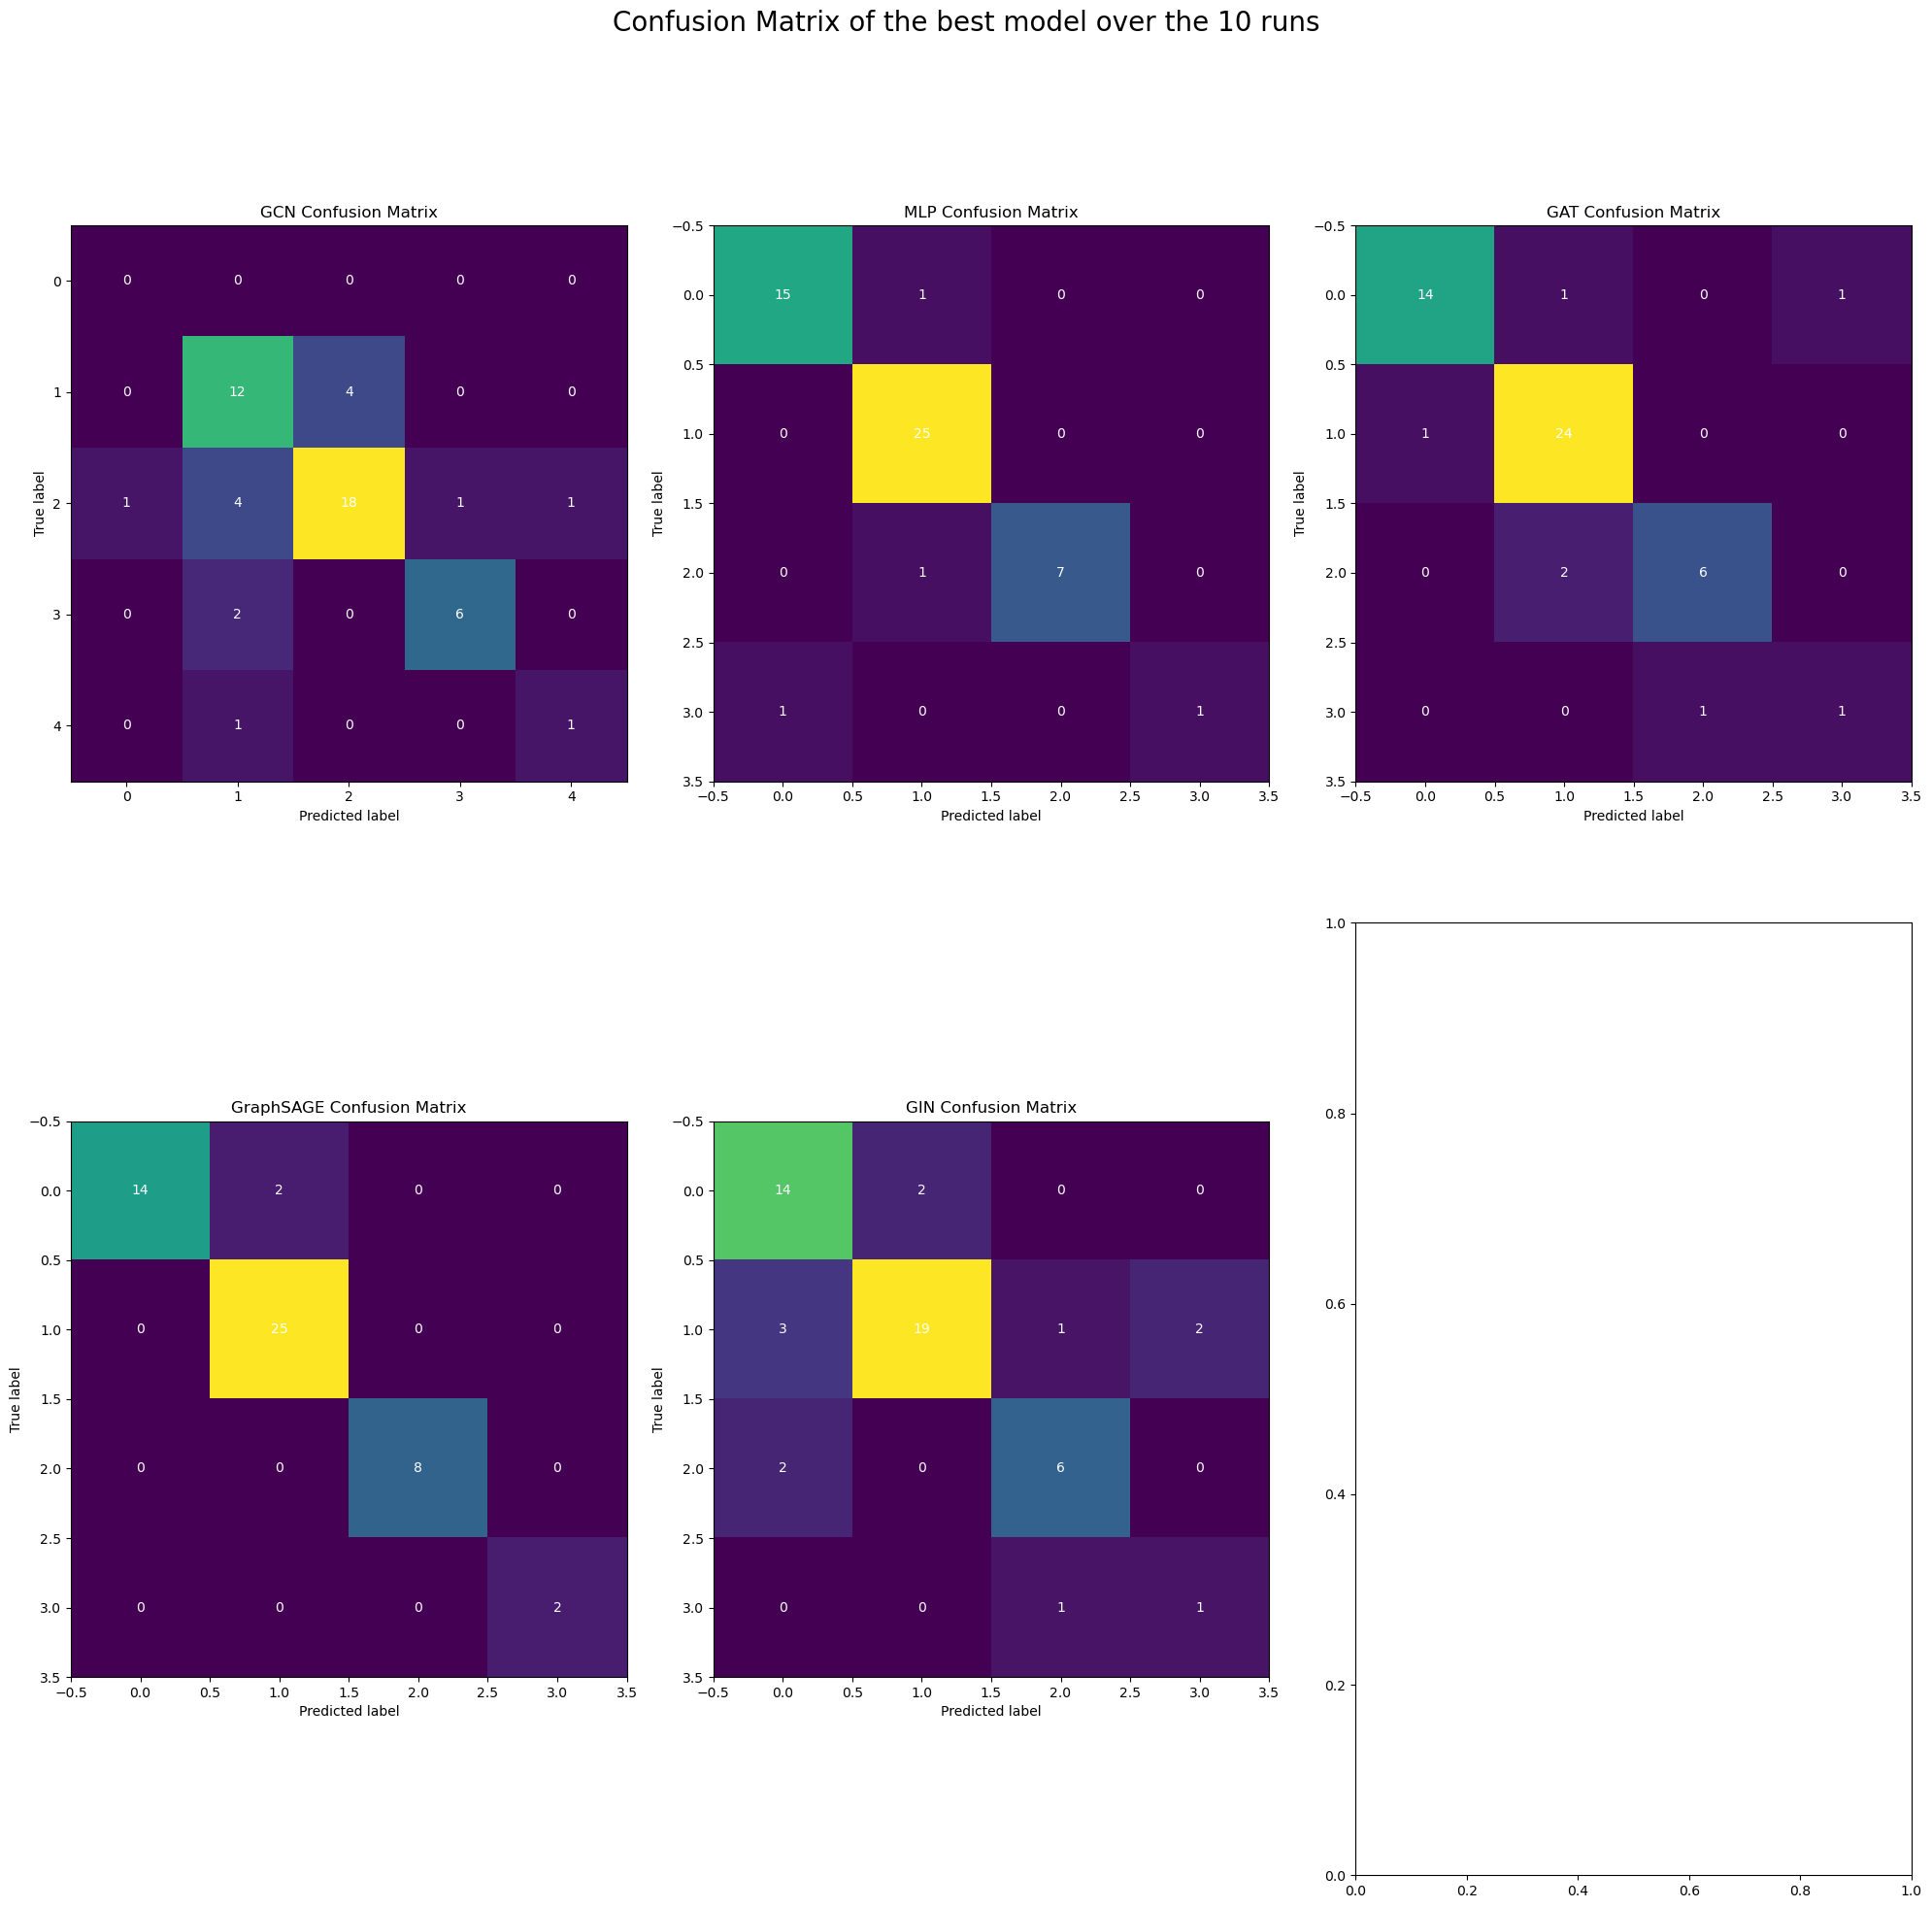

In [27]:
'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, (model, model_name) in enumerate(zip(models4, ['GCN4', 'MLP4', 'GAT4', 'GraphSAGE4', 'GIN4'])):
    conf_matrix = confusion_matrix(data.y[test_mask].cpu(), global_best_models4[i][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=data.y.unique().cpu().numpy())

    row_index = i // 3  
    col_index = i % 3  

    disp.plot(ax=axs[row_index, col_index])
    disp.ax_.set_title(f'{model_name} Confusion Matrix')
    disp.ax_.set_xlabel('Predicted label')
    disp.ax_.set_ylabel('True label')
    disp.im_.colorbar.remove()

fig.suptitle('Confusion Matrix of the best model over the 10 runs', fontsize=20)
plt.tight_layout()
plt.show()
'''
# Otra estrategia por que daba error esta
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, (model, model_name) in enumerate(zip(models4, ['GCN', 'MLP', 'GAT', 'GraphSAGE', 'GIN'])):
    conf_matrix = confusion_matrix(data.y[test_mask].cpu(), global_best_models4[i][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy())

    row_index = i // 3
    col_index = i % 3

    axs[row_index, col_index].imshow(conf_matrix, cmap='viridis', interpolation='nearest')
    axs[row_index, col_index].set_title(f'{model_name} Confusion Matrix')
    axs[row_index, col_index].set_xlabel('Predicted label')
    axs[row_index, col_index].set_ylabel('True label')

    # Adding text annotations
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            axs[row_index, col_index].text(j, i, conf_matrix[i, j], ha='center', va='center', color='white')

fig.suptitle('Confusion Matrix of the best model over the 10 runs', fontsize=20)
plt.tight_layout()
plt.show()

## Basic Models (Spectral Layer without Softmax) Results: Score

In [28]:
# Report the best model over the 10 runs using the test set and sklearn classification report
from sklearn.metrics import classification_report
print('GCN4')
print(classification_report(data.y[test_mask].cpu(), global_best_models4[0][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('MLP4')
print(classification_report(data.y[test_mask].cpu(), global_best_models4[1][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GAT4')
print(classification_report(data.y[test_mask].cpu(), global_best_models4[2][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GraphSAGE4')
print(classification_report(data.y[test_mask].cpu(), global_best_models4[3][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

print('========================================================================')

print('GIN4')
print(classification_report(data.y[test_mask].cpu(), global_best_models4[4][0](data.x, data.edge_index).argmax(dim=1)[test_mask].detach().cpu().numpy()))

GCN4
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.63      0.75      0.69        16
           2       0.82      0.72      0.77        25
           3       0.86      0.75      0.80         8
           4       0.50      0.50      0.50         2

    accuracy                           0.73        51
   macro avg       0.56      0.54      0.55        51
weighted avg       0.75      0.73      0.74        51

MLP4
              precision    recall  f1-score   support

           1       0.94      0.94      0.94        16
           2       0.93      1.00      0.96        25
           3       1.00      0.88      0.93         8
           4       1.00      0.50      0.67         2

    accuracy                           0.94        51
   macro avg       0.97      0.83      0.87        51
weighted avg       0.94      0.94      0.94        51

GAT4
              precision    recall  f1-score   support

      